In [ ]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# Load the Data
# Data from https://data.cdc.gov/Nutrition-Physical-Activity-and-Obesity/Nutrition-Physical-Activity-and-Obesity-Behavioral/hn4x-zwk7/about_data

filename = "Nutrition__Physical_Activity__and_Obesity_-_Behavioral_Risk_Factor_Surveillance_System.csv"
#Features
with open(filename, 'r') as f:
    features = f.readline().strip().split(',')
print(features)

if len(features) == 0:
    print("No features found")
    exit(1)

df = pd.read_csv(filename, names=features, header=1)

# Drop Features
df = df.drop(['YearEnd', 'Class', 'LocationAbbr', 'Datasource', 'Topic', 'Data_Value_Type', 'Data_Value_Alt', 'Data_Value_Footnote_Symbol', 'Data_Value_Footnote', 'DataValueTypeID', 'LocationID', 'StratificationCategoryId1', 'StratificationID1', 'Data_Value_Unit'], axis=1)

#Makes things easier later
print(df.head())

['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'Datasource', 'Class', 'Topic', 'Question', 'Data_Value_Unit', 'Data_Value_Type', 'Data_Value', 'Data_Value_Alt', 'Data_Value_Footnote_Symbol', 'Data_Value_Footnote', 'Low_Confidence_Limit', 'High_Confidence_Limit ', 'Sample_Size', 'Total', 'Age(years)', 'Education', 'Gender', 'Income', 'Race/Ethnicity', 'GeoLocation', 'ClassID', 'TopicID', 'QuestionID', 'DataValueTypeID', 'LocationID', 'StratificationCategory1', 'Stratification1', 'StratificationCategoryId1', 'StratificationID1']
   YearStart LocationDesc                                           Question  \
0       2011       Alaska  Percent of adults aged 18 years and older who ...   
1       2011       Alaska  Percent of adults who achieve at least 150 min...   
2       2011       Alaska  Percent of adults aged 18 years and older who ...   
3       2011       Alaska  Percent of adults aged 18 years and older who ...   
4       2011       Alaska  Percent of adults aged 18 year

In [3]:
# Save new CSV
df.to_csv('data-modified.csv', index=False)

In [4]:

print('Features: ' , df.columns)
stratIDS = df['StratificationCategory1'].unique()
questionUnique = df['Question'].unique()
questionIDS = df['QuestionID'].unique()
print("Strat IDS: ", stratIDS)
# Question IDs Map might be helpful later idk
#qID_map = {}
#for i, k in enumerate(questionIDS):
#    qID_map[k] = questionUnique[i]
#print(qID_map)



Features:  Index(['YearStart', 'LocationDesc', 'Question', 'Data_Value',
       'Low_Confidence_Limit', 'High_Confidence_Limit ', 'Sample_Size',
       'Total', 'Age(years)', 'Education', 'Gender', 'Income',
       'Race/Ethnicity', 'GeoLocation', 'ClassID', 'TopicID', 'QuestionID',
       'StratificationCategory1', 'Stratification1'],
      dtype='object')
Strat IDS:  ['Race/Ethnicity' 'Gender' 'Age (years)' 'Income' 'Education' 'Total']


In [5]:
# There are different types of data
# Create a new dataframe for each
# Split by ClassID? Split by StratificationCategoryID1?

# Split by StratificationCategoryID1 Because the nan values are dependent on these.
    # Forexample the Gender will be NAN if the row is refereing to income. Will have to deal with the specific questions later
    # Then we will drop the categories that don't line up
df[df['StratificationCategory1'] == 'Race/Ethnicity'].copy(deep=True)

race_df = df[df['StratificationCategory1'] == 'Race/Ethnicity'].copy(deep=True)
gender_df = df[df['StratificationCategory1'] == 'Gender'].copy(deep=True)
age_df = df[df['StratificationCategory1'] == 'Age (years)'].copy(deep=True)
income_df = df[df['StratificationCategory1'] == 'Income'].copy(deep=True)
education_df = df[df['StratificationCategory1'] == 'Education'].copy(deep=True)
total_df = df[df['StratificationCategory1'] == 'Total'].copy(deep=True)

race_df = race_df.drop([ 'Gender', 'Age(years)', 'Income', 'Education', 'Total'], axis=1)
gender_df = gender_df.drop(['Race/Ethnicity', 'Age(years)', 'Income', 'Education', 'Total'], axis=1)
age_df = age_df.drop(['Race/Ethnicity', 'Gender', 'Income', 'Education', 'Total'], axis=1)
income_df = income_df.drop(['Race/Ethnicity', 'Gender', 'Age(years)', 'Education', 'Total'], axis=1)
education_df = education_df.drop(['Race/Ethnicity', 'Gender', 'Age(years)', 'Income', 'Total'], axis=1)
total_df = total_df.drop(['Race/Ethnicity', 'Gender', 'Age(years)', 'Income', 'Education'], axis=1)




In [6]:
# Race
print(race_df.head())
print('Size of DF: ', race_df.size)
print('Number of NAN: ', race_df.size)


    YearStart LocationDesc                                           Question  \
0        2011       Alaska  Percent of adults aged 18 years and older who ...   
7        2011       Alaska  Percent of adults who engage in muscle-strengt...   
8        2011       Alaska  Percent of adults who achieve at least 300 min...   
9        2011       Alaska  Percent of adults aged 18 years and older who ...   
11       2011       Alaska  Percent of adults who achieve at least 150 min...   

    Data_Value  Low_Confidence_Limit  High_Confidence_Limit   Sample_Size  \
0         35.5                  22.7                    50.9         63.0   
7         35.9                  33.2                    38.6       2417.0   
8          NaN                   NaN                     NaN          NaN   
9          NaN                   NaN                     NaN          NaN   
11         NaN                   NaN                     NaN          NaN   

        Race/Ethnicity                        GeoL

In [7]:
# Gender
print(gender_df.head())
print('Size of DF: ', gender_df.size)
print('Number of NAN: ', gender_df.isnull().sum())


    YearStart LocationDesc                                           Question  \
1        2011       Alaska  Percent of adults who achieve at least 150 min...   
4        2011       Alaska  Percent of adults aged 18 years and older who ...   
10       2011       Alaska  Percent of adults aged 18 years and older who ...   
18       2011       Alaska  Percent of adults aged 18 years and older who ...   
22       2011       Alaska  Percent of adults aged 18 years and older who ...   

    Data_Value  Low_Confidence_Limit  High_Confidence_Limit   Sample_Size  \
1         21.7                  19.1                    24.6       1702.0   
4         28.0                  24.9                    31.3       1620.0   
10        26.7                  23.9                    29.7       1716.0   
18        31.3                  28.1                    34.6       1716.0   
22        45.3                  41.8                    48.9       1620.0   

    Gender                        GeoLocation Clas

In [8]:
# Age
print(age_df.head())
print('Size of DF: ', age_df.size)
print('Number of NAN: ', age_df.isnull().sum())


    YearStart LocationDesc                                           Question  \
2        2011       Alaska  Percent of adults aged 18 years and older who ...   
6        2011       Alaska  Percent of adults aged 18 years and older who ...   
14       2011       Alaska  Percent of adults aged 18 years and older who ...   
26       2011       Alaska  Percent of adults who achieve at least 150 min...   
30       2011       Alaska  Percent of adults who engage in no leisure-tim...   

    Data_Value  Low_Confidence_Limit  High_Confidence_Limit   Sample_Size  \
2         29.5                  24.5                    35.0        562.0   
6         38.7                  32.7                    45.2        451.0   
14        32.0                  24.7                    40.4        212.0   
26        34.9                  26.8                    43.9        200.0   
30        21.1                  16.9                    26.1        561.0   

   Age(years)                        GeoLocation C

In [9]:
# Income
print(income_df.head())
print('Size of DF: ', income_df.size)
print('Number of NAN: ', income_df.isnull().sum())


    YearStart LocationDesc                                           Question  \
3        2011       Alaska  Percent of adults aged 18 years and older who ...   
12       2011       Alaska  Percent of adults who achieve at least 150 min...   
15       2011       Alaska  Percent of adults who engage in no leisure-tim...   
20       2011       Alaska  Percent of adults aged 18 years and older who ...   
21       2011       Alaska  Percent of adults aged 18 years and older who ...   

    Data_Value  Low_Confidence_Limit  High_Confidence_Limit   Sample_Size  \
3         33.5                  26.2                    41.7        377.0   
12        17.3                  12.5                    23.4        349.0   
15        19.2                  15.1                    24.1        530.0   
20        39.9                  36.0                    44.0       1109.0   
21        41.6                  35.8                    47.6        524.0   

                Income                        GeoL

In [10]:
# Education
print(education_df.head())
print('Size of DF: ', education_df.size)
print('Number of NAN: ', education_df.isnull().sum())


    YearStart LocationDesc                                           Question  \
5        2011       Alaska  Percent of adults who engage in muscle-strengt...   
13       2011       Alaska  Percent of adults aged 18 years and older who ...   
19       2011       Alaska  Percent of adults who achieve at least 300 min...   
25       2011       Alaska  Percent of adults who achieve at least 150 min...   
27       2011       Alaska  Percent of adults who engage in muscle-strengt...   

    Data_Value  Low_Confidence_Limit  High_Confidence_Limit   Sample_Size  \
5         28.8                  21.9                    36.8        232.0   
13        25.8                  22.3                    29.6        954.0   
19        30.1                  26.1                    34.3        910.0   
25        67.2                  63.3                    70.9       1130.0   
27        41.8                  38.0                    45.8       1151.0   

                           Education              

In [11]:
# Total - Is the overall percentage of the given question given a location
print(total_df.head())
print('Size of DF: ', total_df.size)
print('Number of NAN: ', total_df.isnull().sum())


     YearStart LocationDesc  \
52        2011       Alaska   
80        2011       Alaska   
103       2011       Alaska   
126       2011       Alaska   
156       2011       Alaska   

                                              Question  Data_Value  \
52   Percent of adults aged 18 years and older who ...        27.4   
80   Percent of adults who engage in muscle-strengt...        33.8   
103  Percent of adults who achieve at least 150 min...        57.9   
126  Percent of adults aged 18 years and older who ...        38.9   
156  Percent of adults who achieve at least 300 min...        37.7   

     Low_Confidence_Limit  High_Confidence_Limit   Sample_Size  Total  \
52                   25.3                    29.7       3336.0  Total   
80                   31.5                    36.3       3294.0  Total   
103                  55.4                    60.4       3212.0  Total   
126                  36.5                    41.3       3336.0  Total   
156                  35.3  

In [12]:
# Dropping Rows in all data frames where the sample size is NAN and where the GeoLocation is NAN.
#   GeoLocation because the project is dependent on the location
#   Sample Size for Obvious reasons plus we have enough data
race_df = race_df.dropna()
gender_df = gender_df.dropna()
age_df = age_df.dropna()
income_df = income_df.dropna()
education_df = education_df.dropna()
total_df = total_df.dropna()

# Check the Sizes to make sure everything is ok
print('Size of race DF: ', race_df.size)
print('Size of gender DF: ', gender_df.size)
print('Size of income DF: ', income_df.size)
print('Size of education DF: ', education_df.size)
print('Size of total DF: ', total_df.size)



Size of race DF:  269920
Size of gender DF:  101220
Size of income DF:  354200
Size of education DF:  202440
Size of total DF:  50610


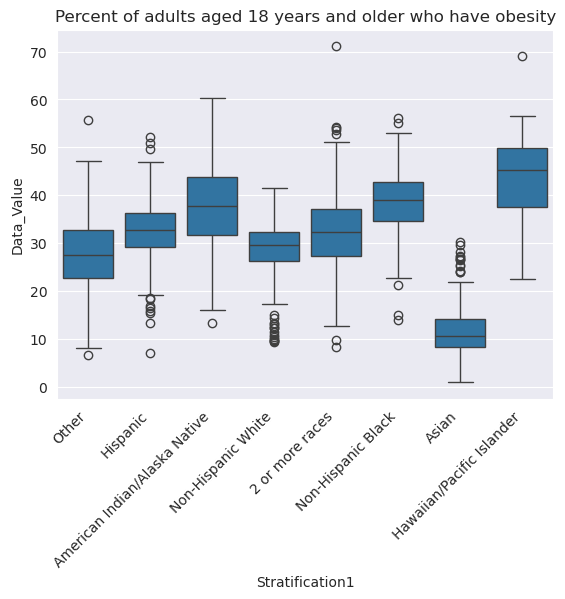

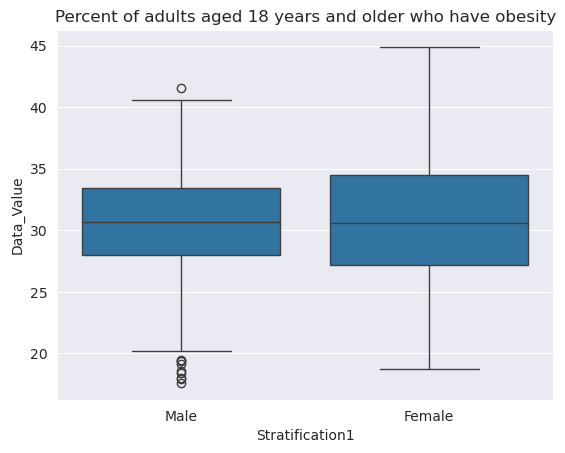

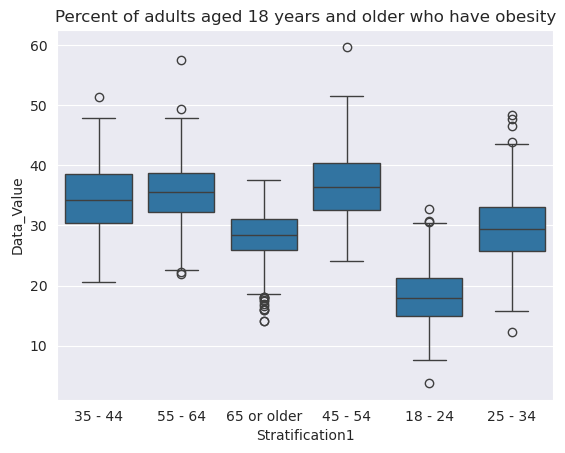

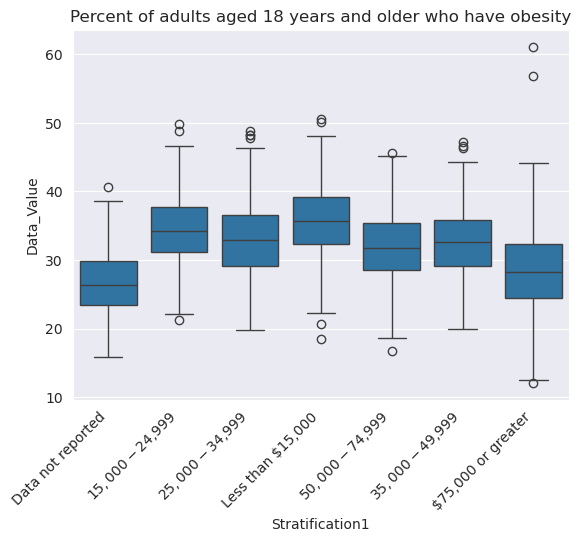

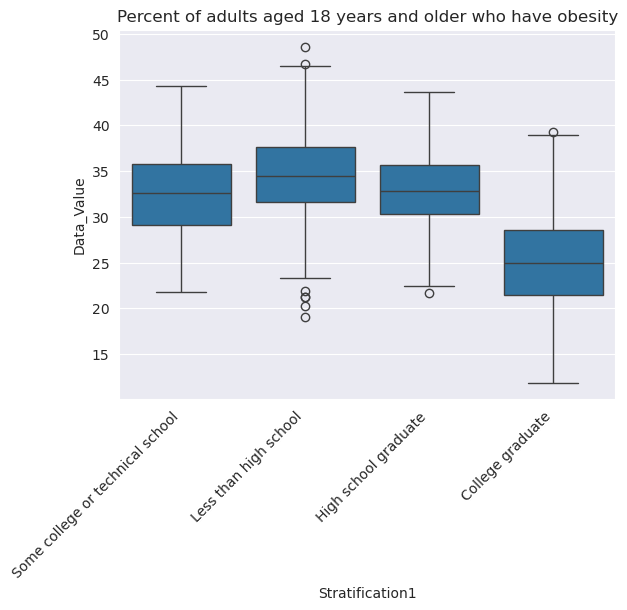

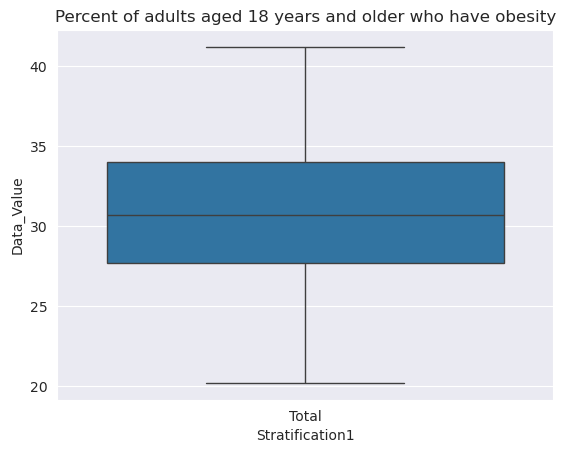

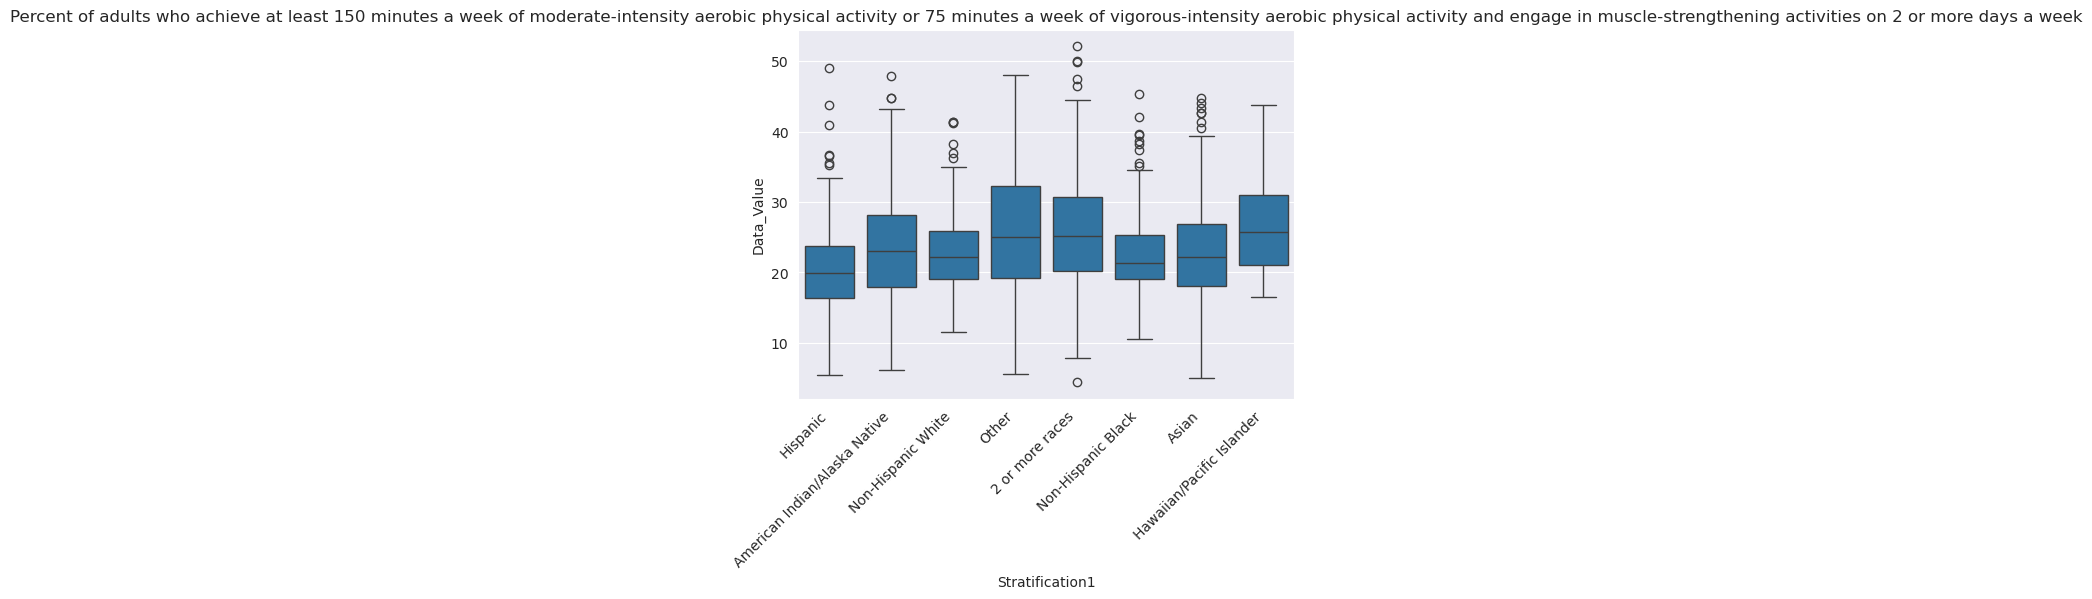

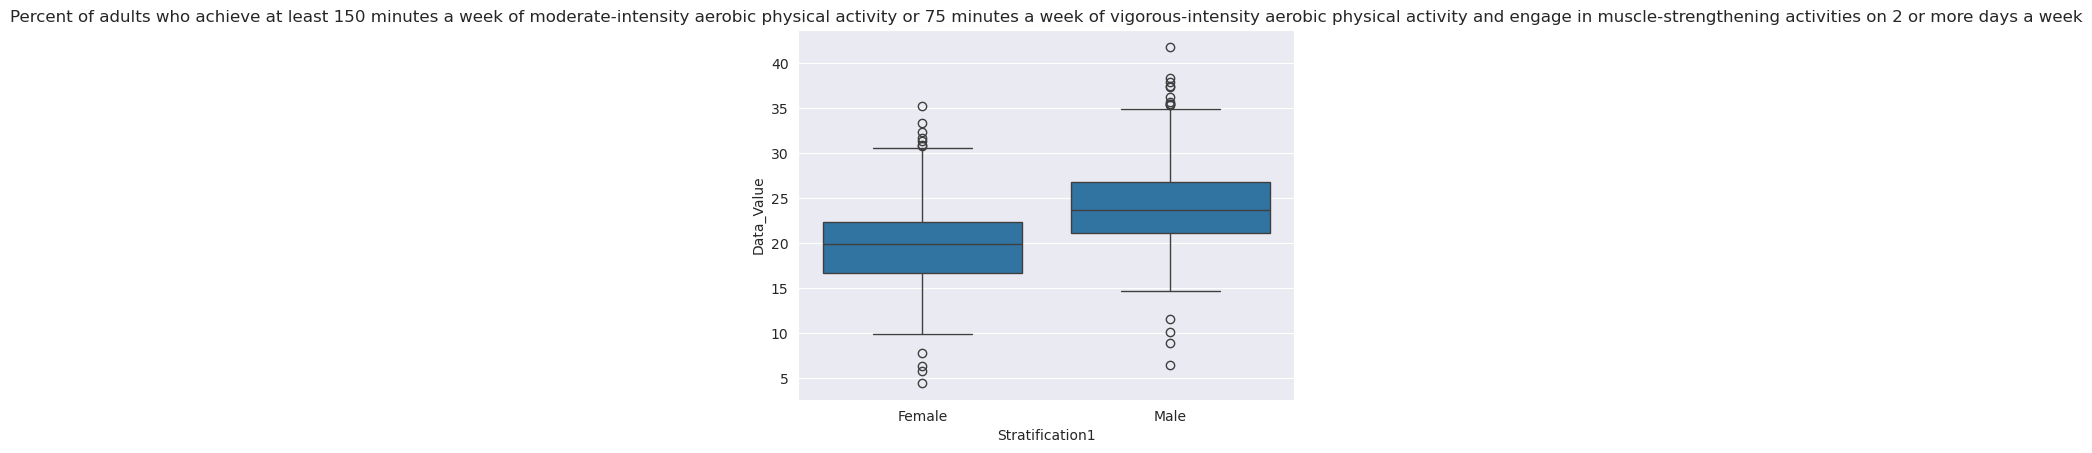

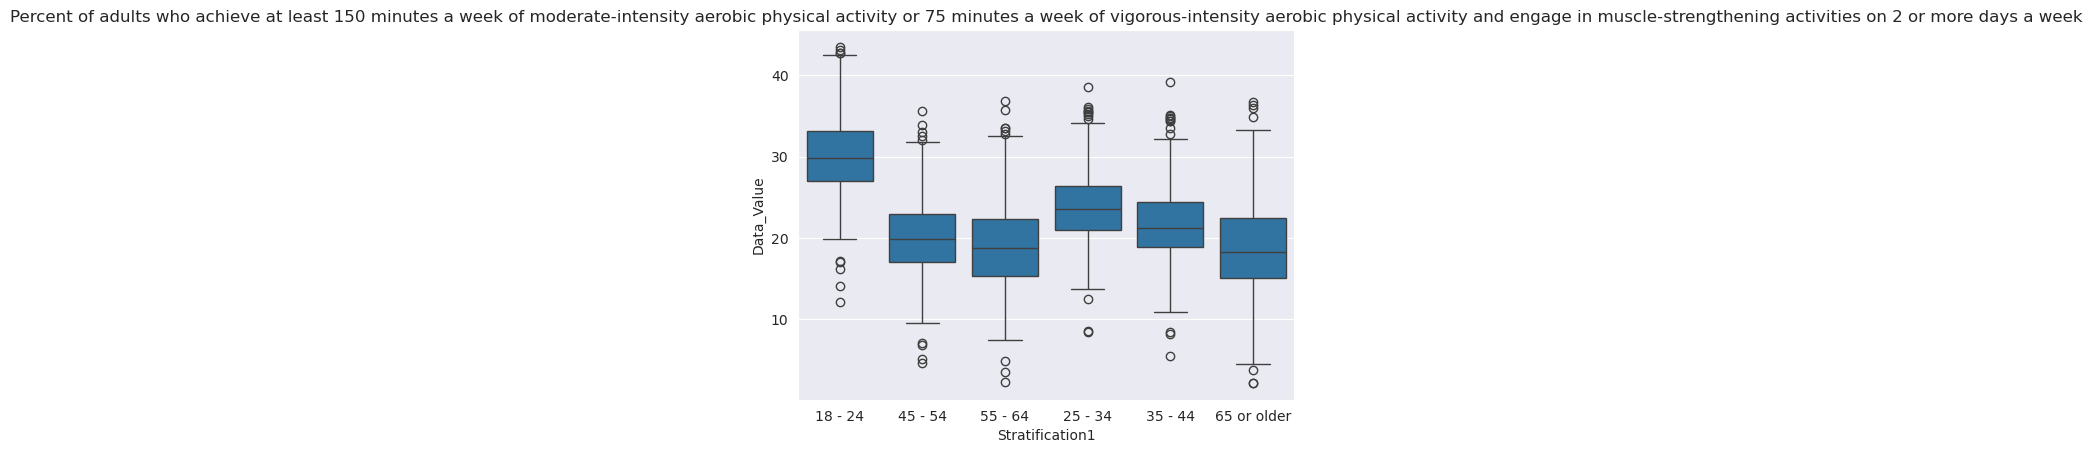

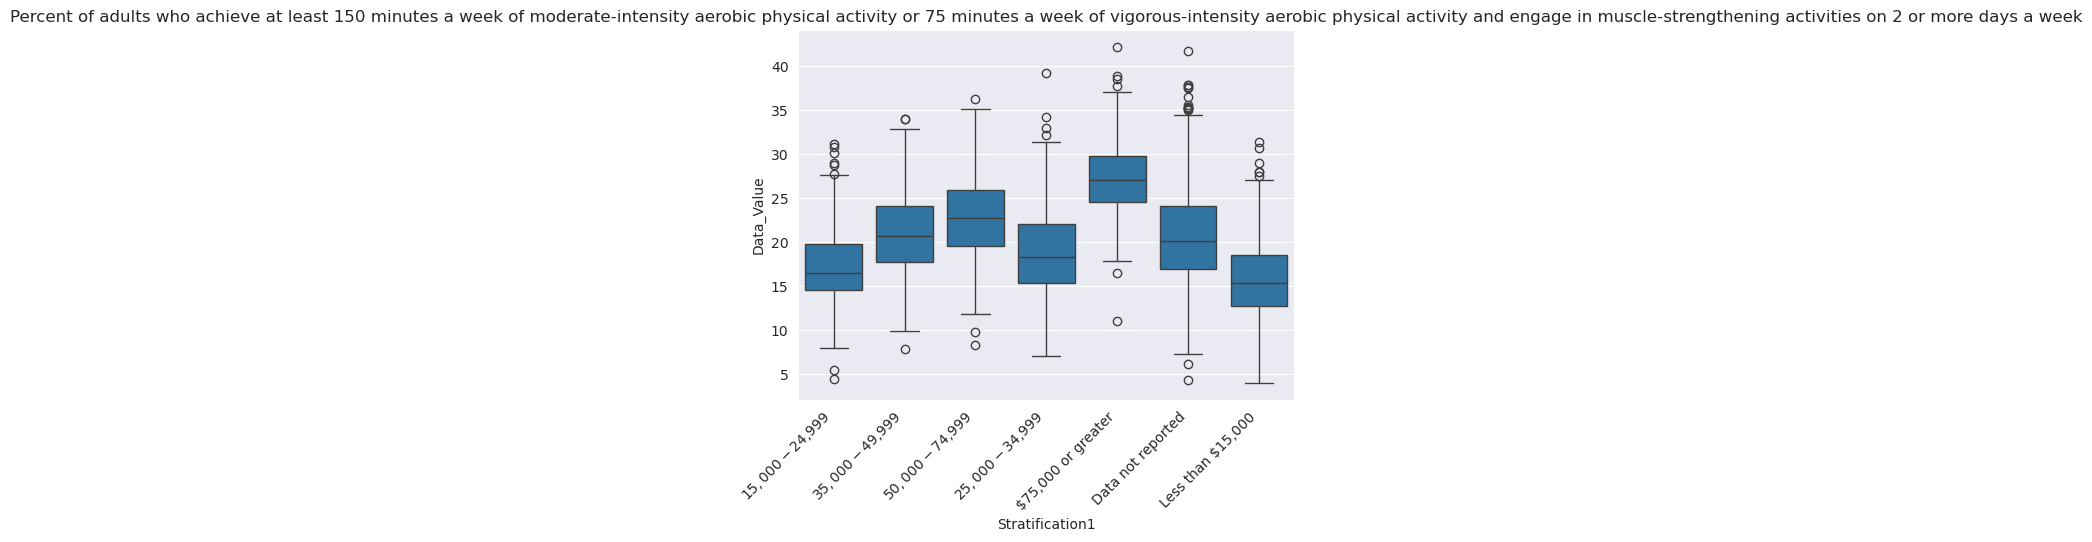

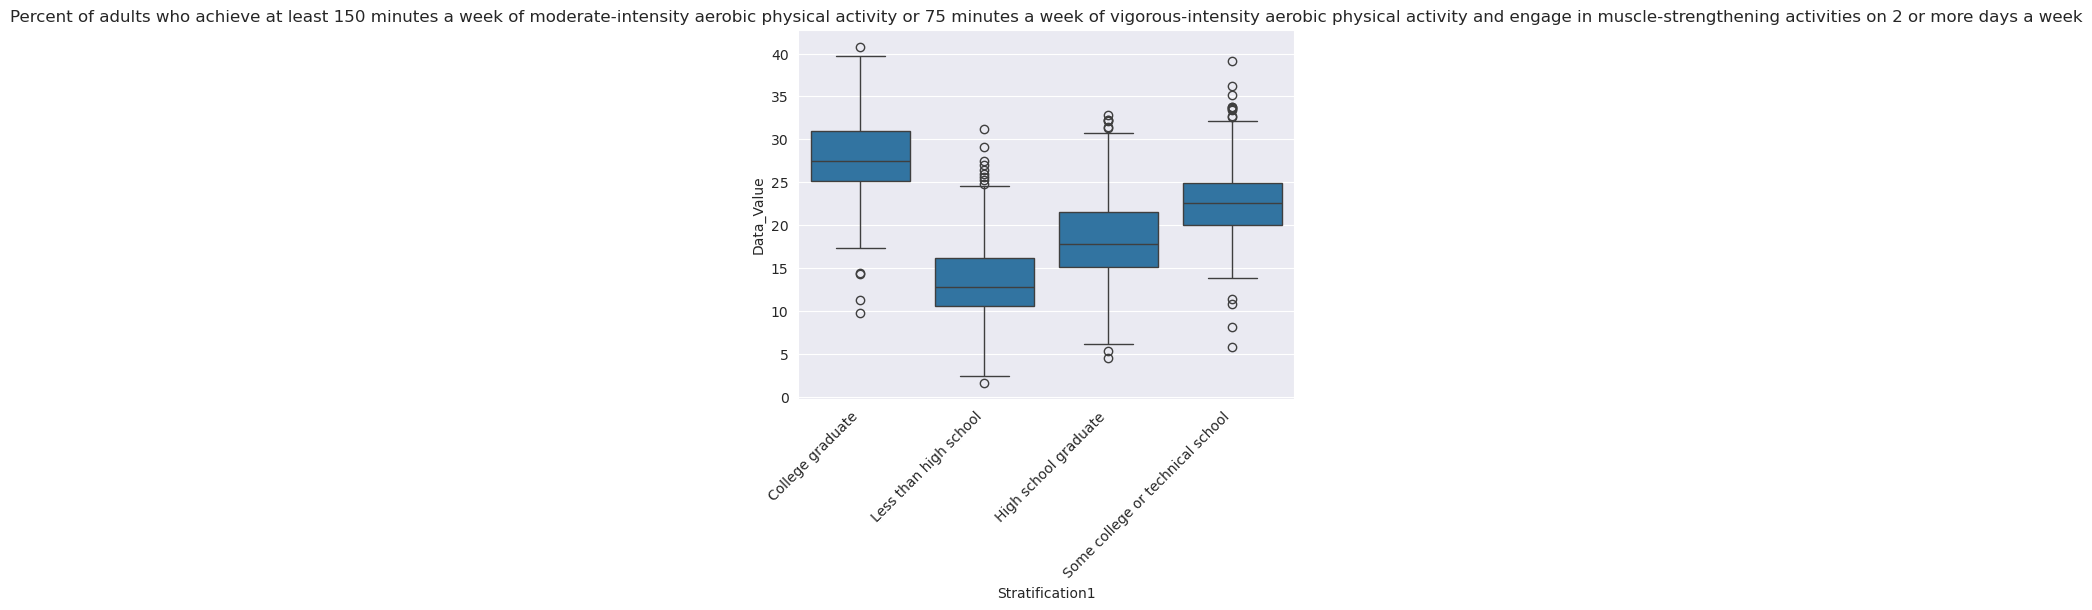

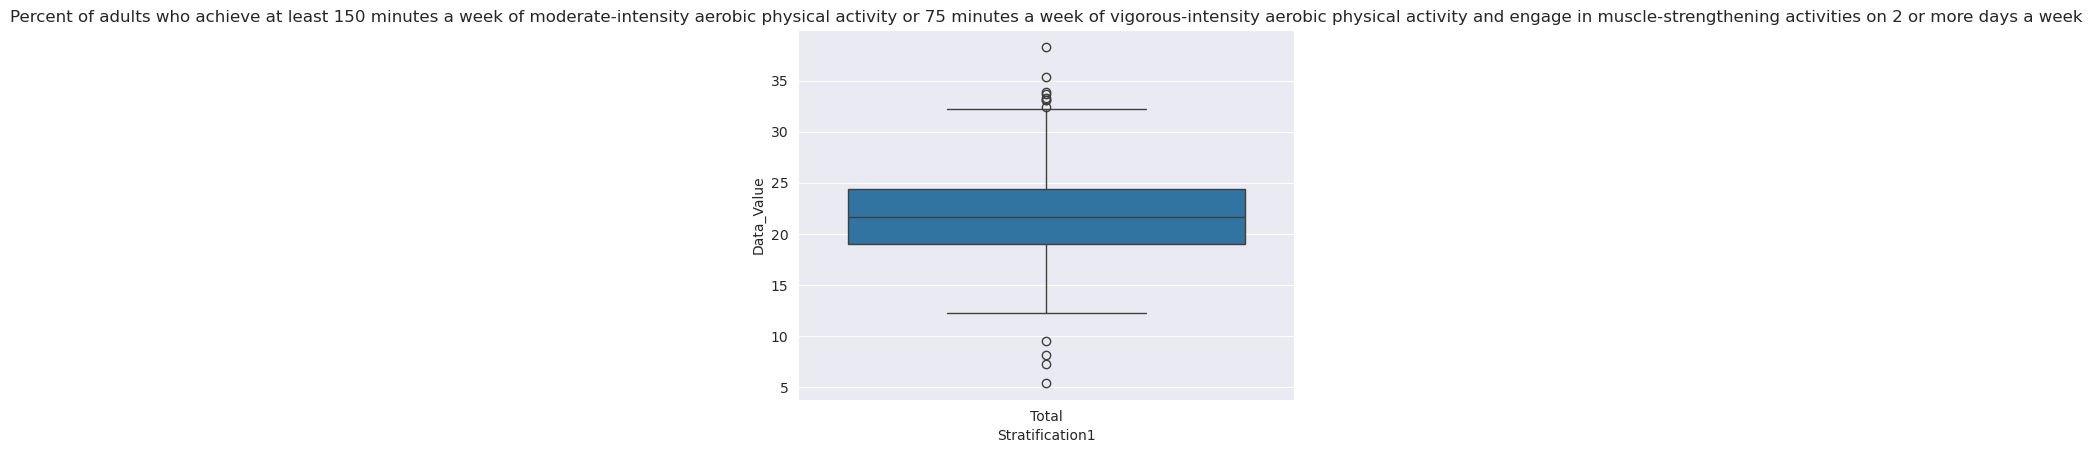

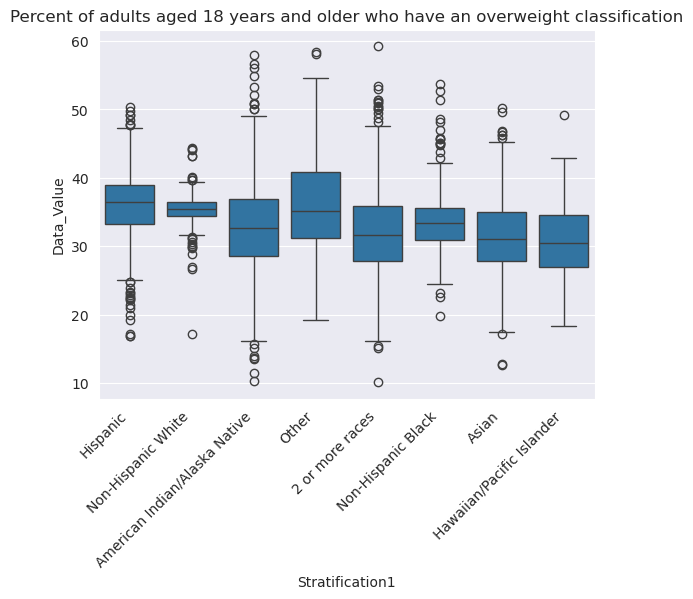

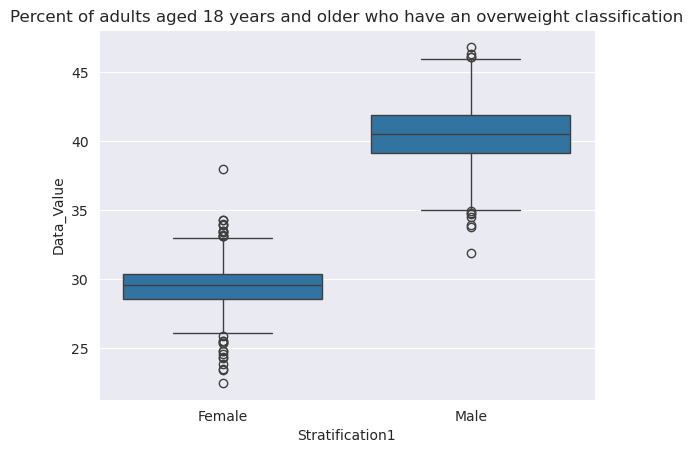

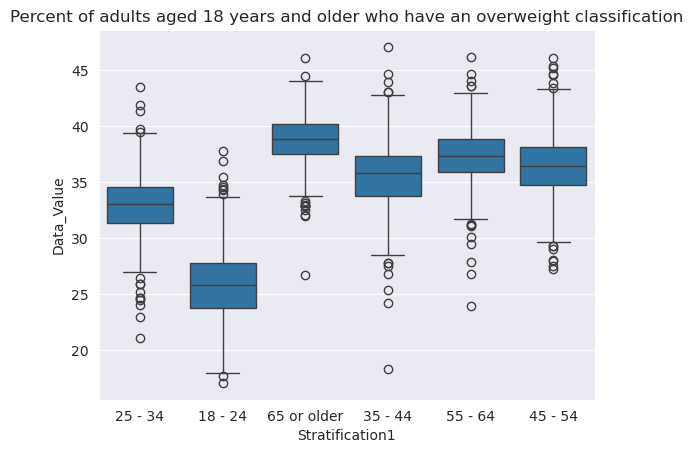

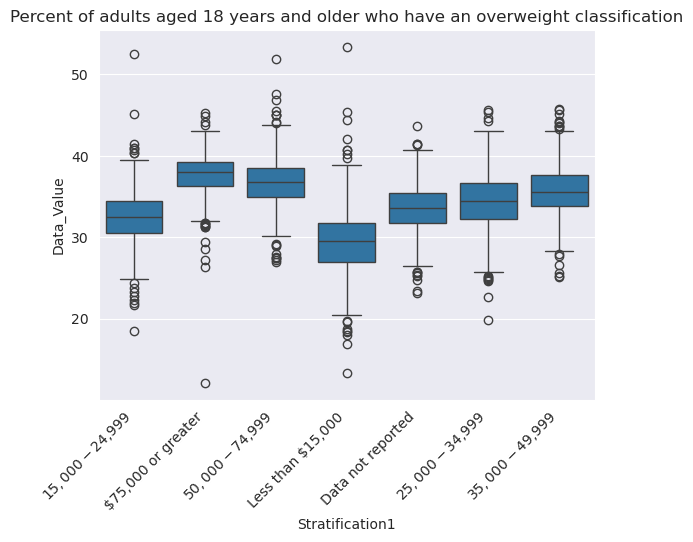

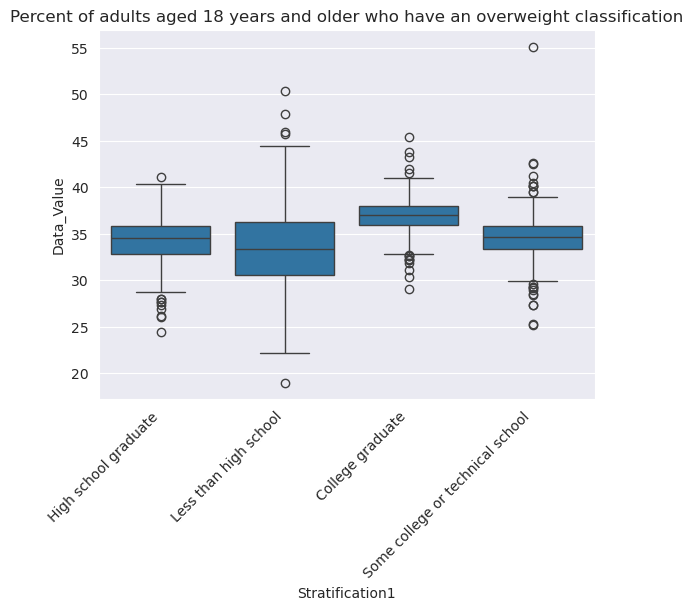

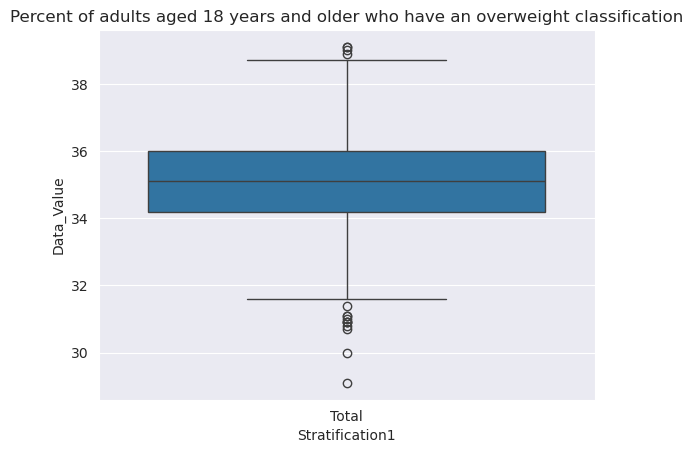

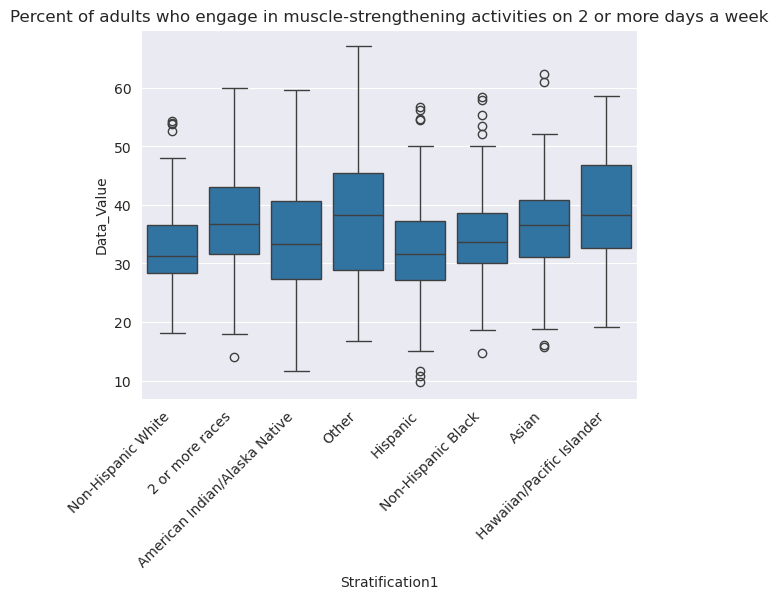

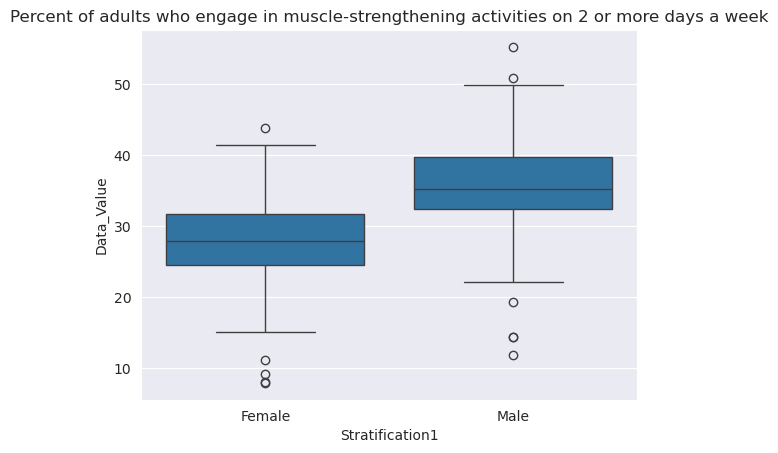

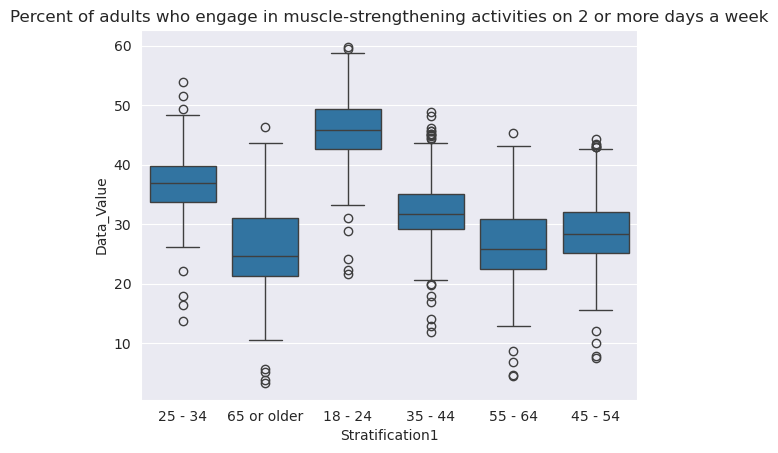

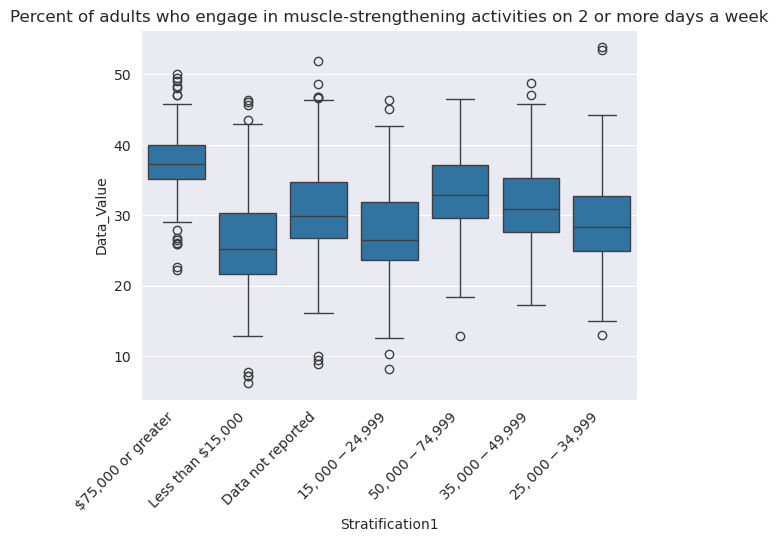

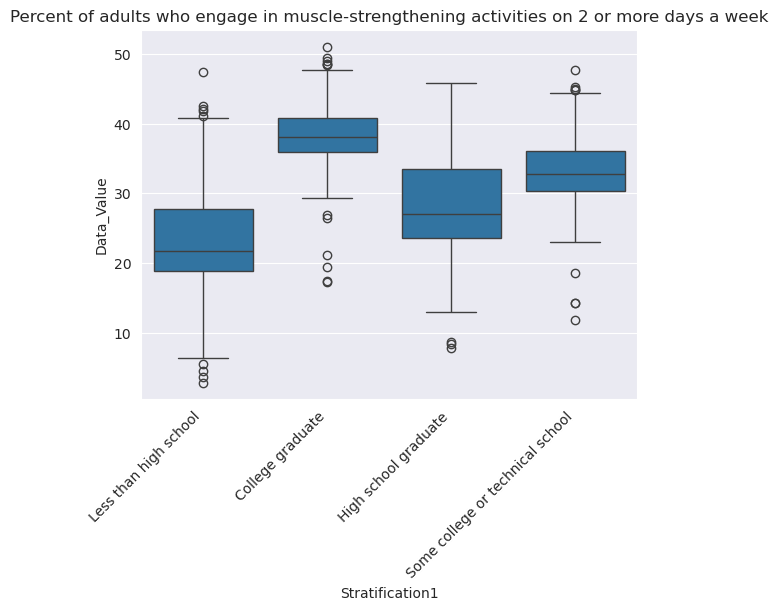

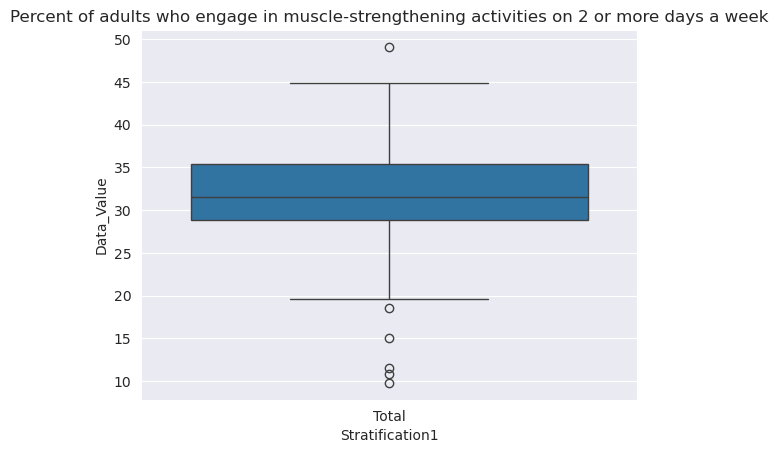

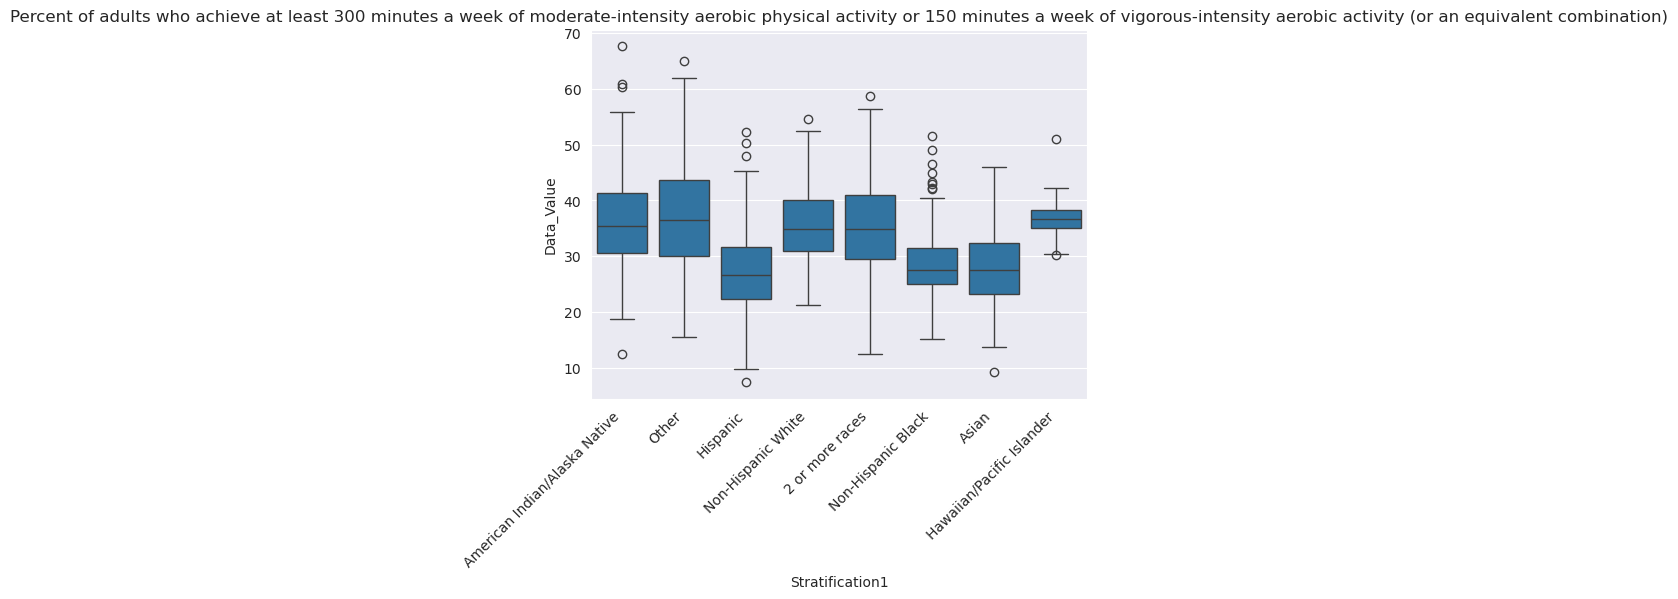

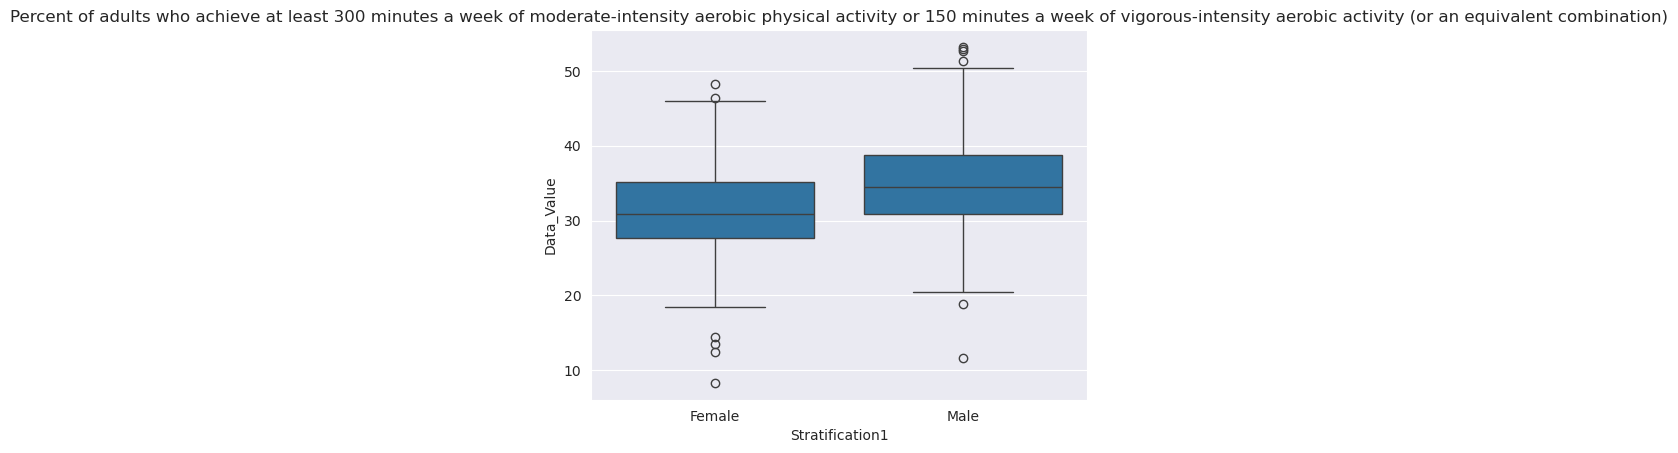

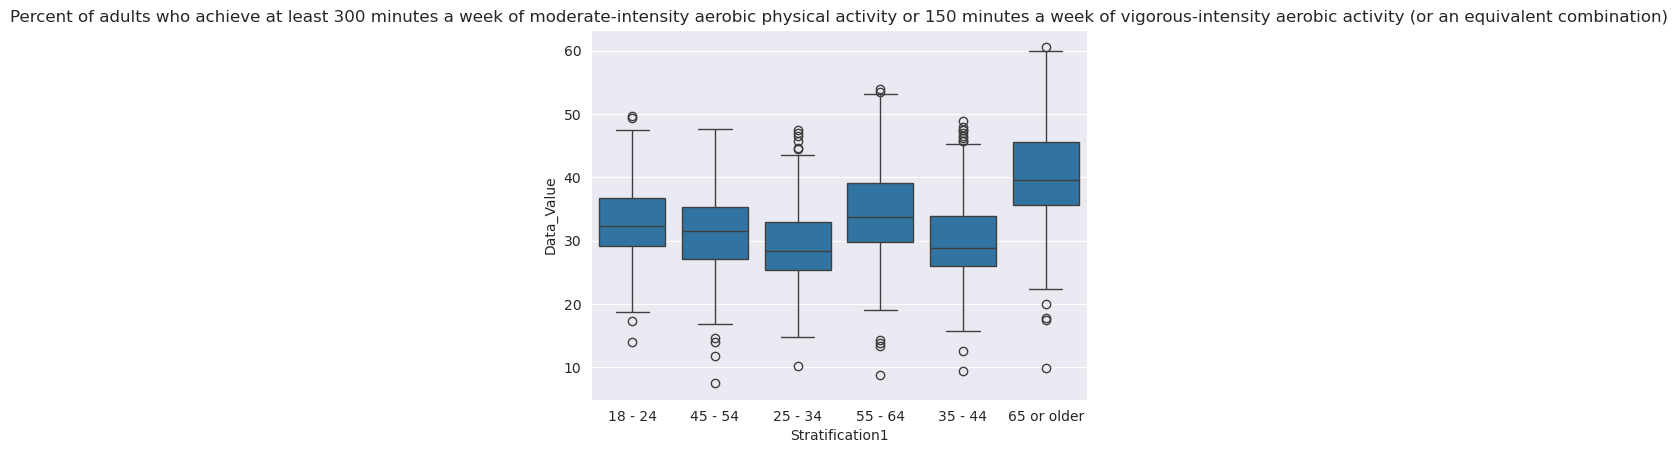

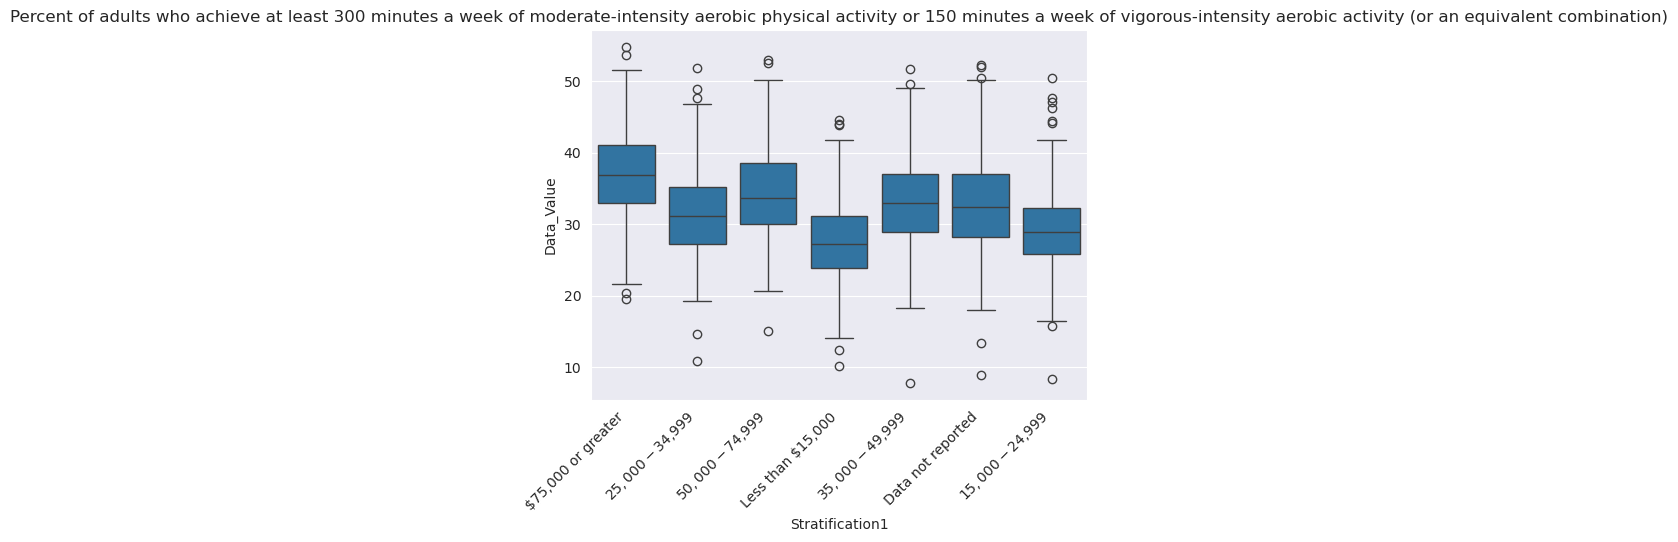

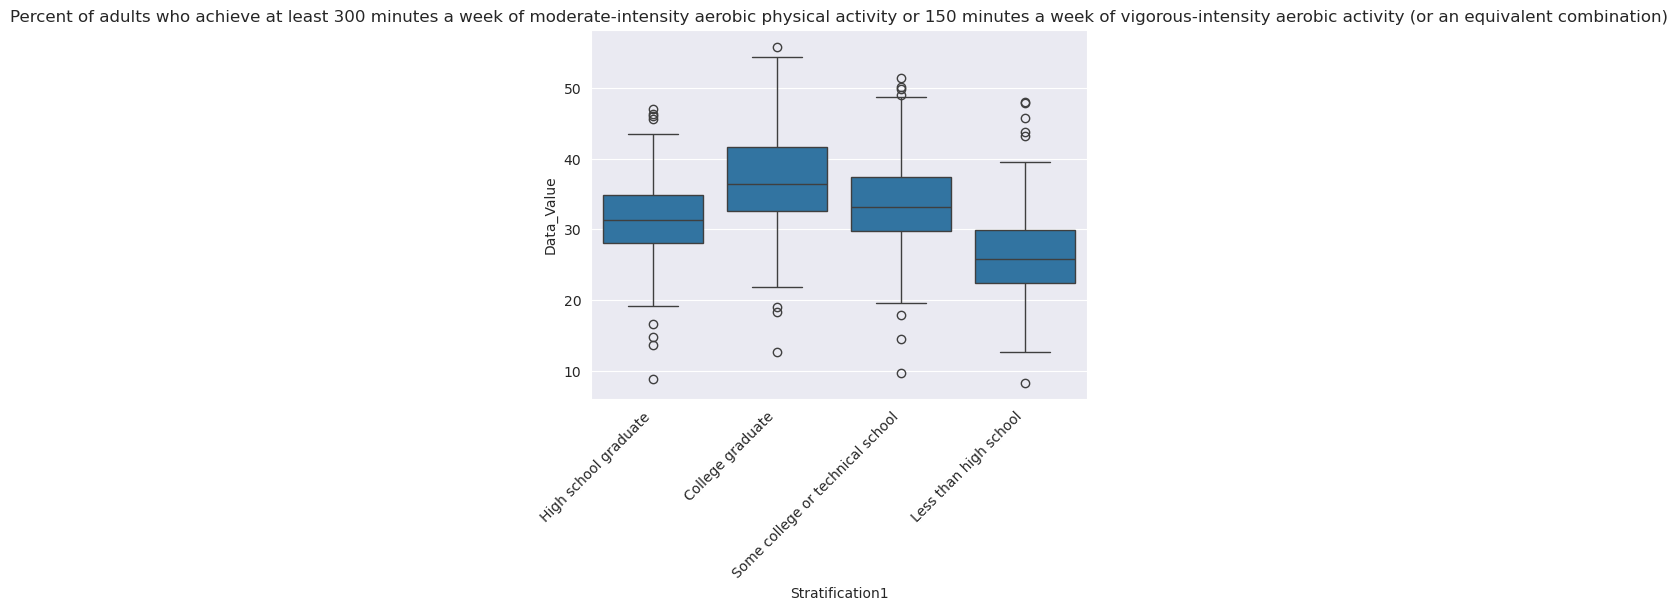

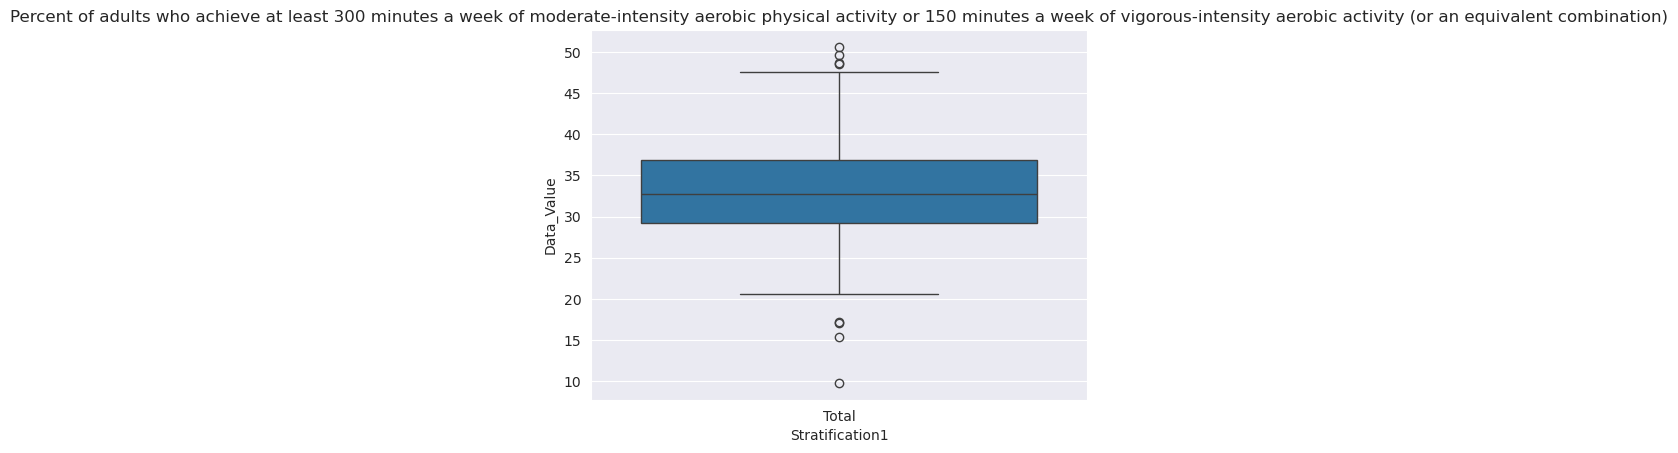

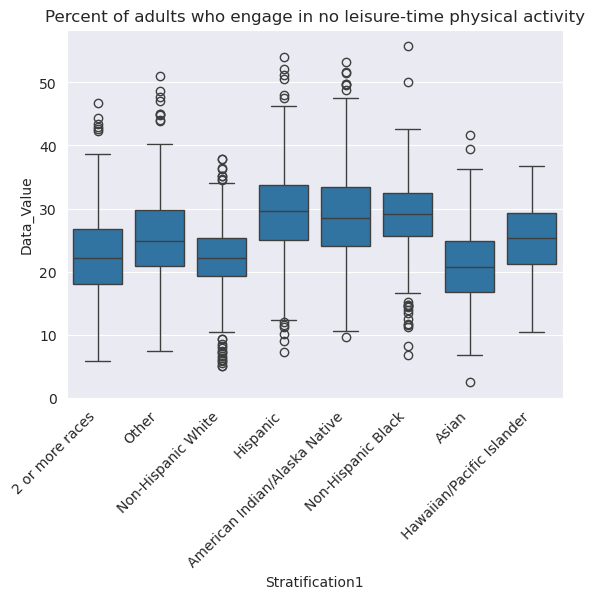

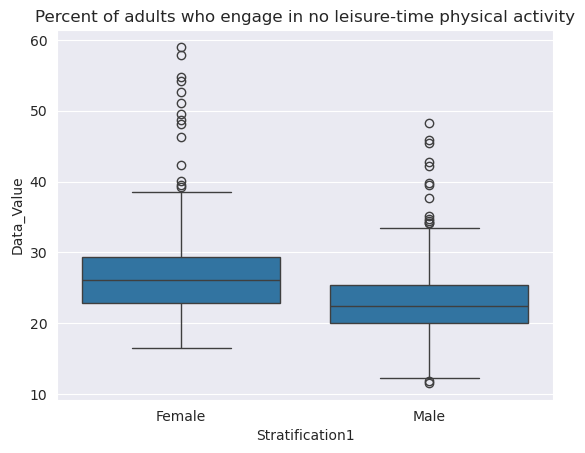

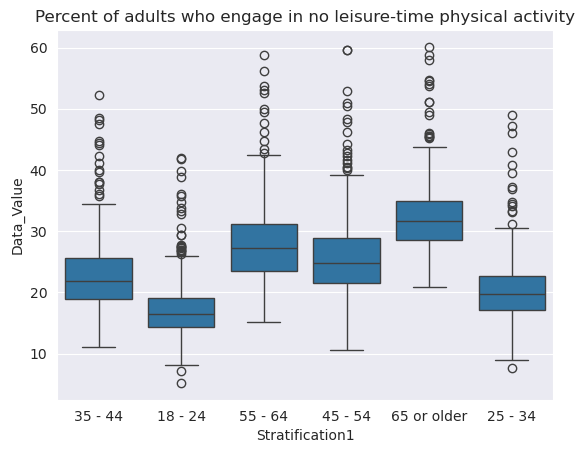

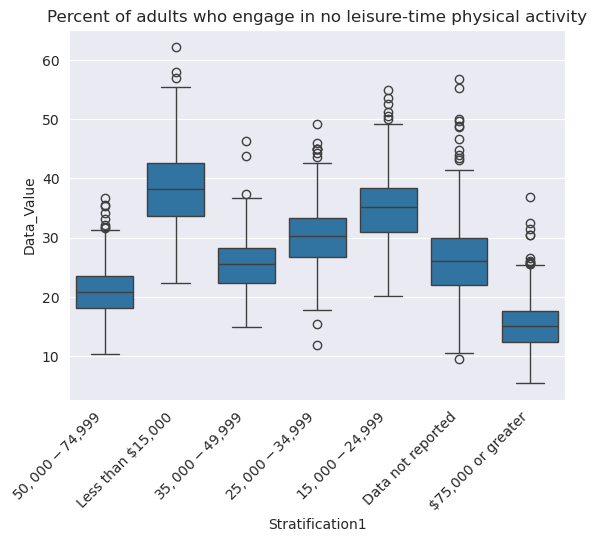

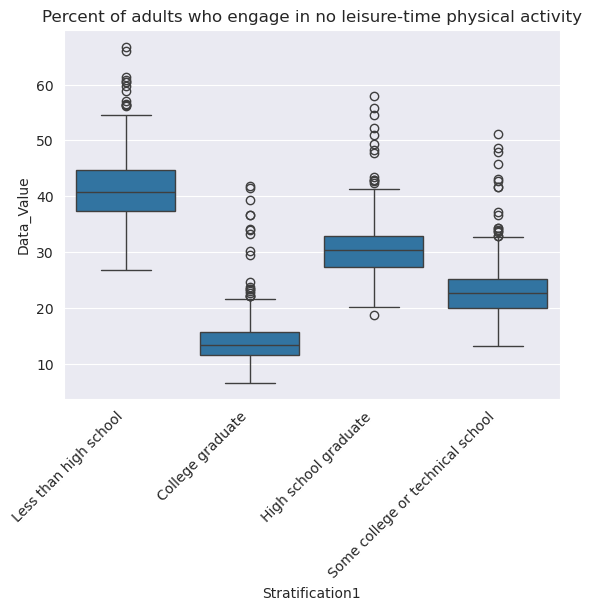

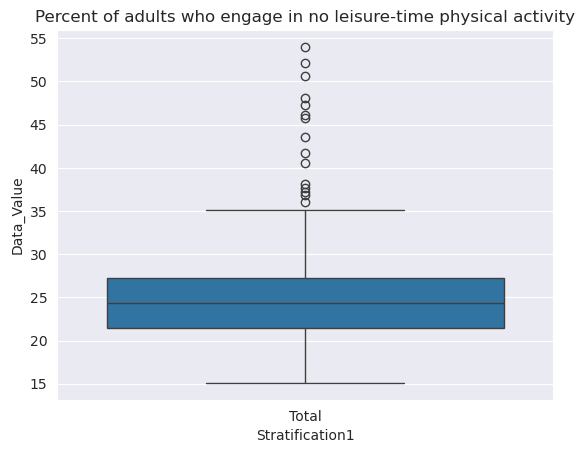

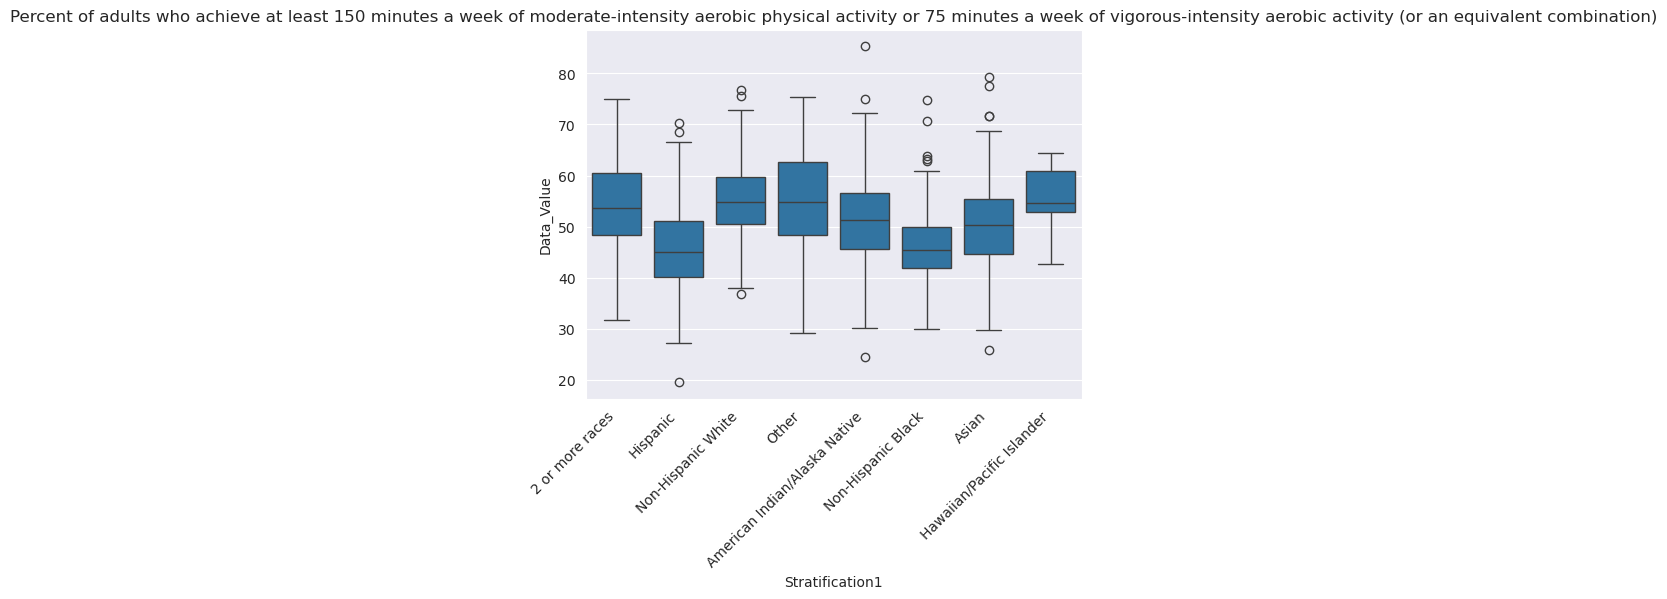

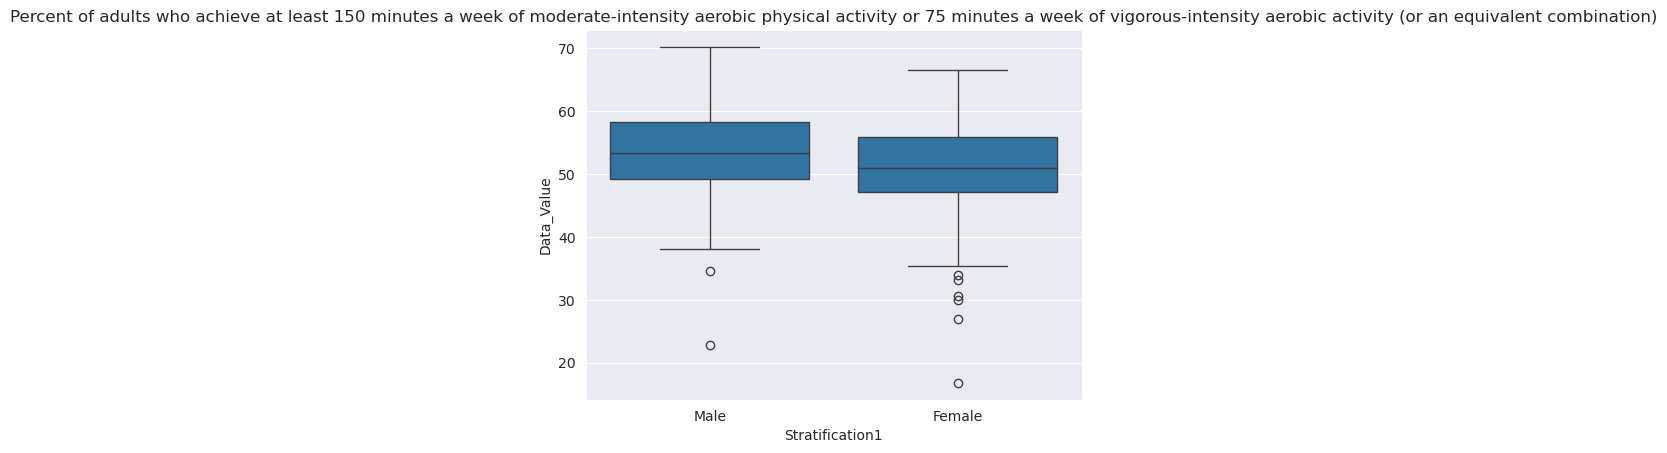

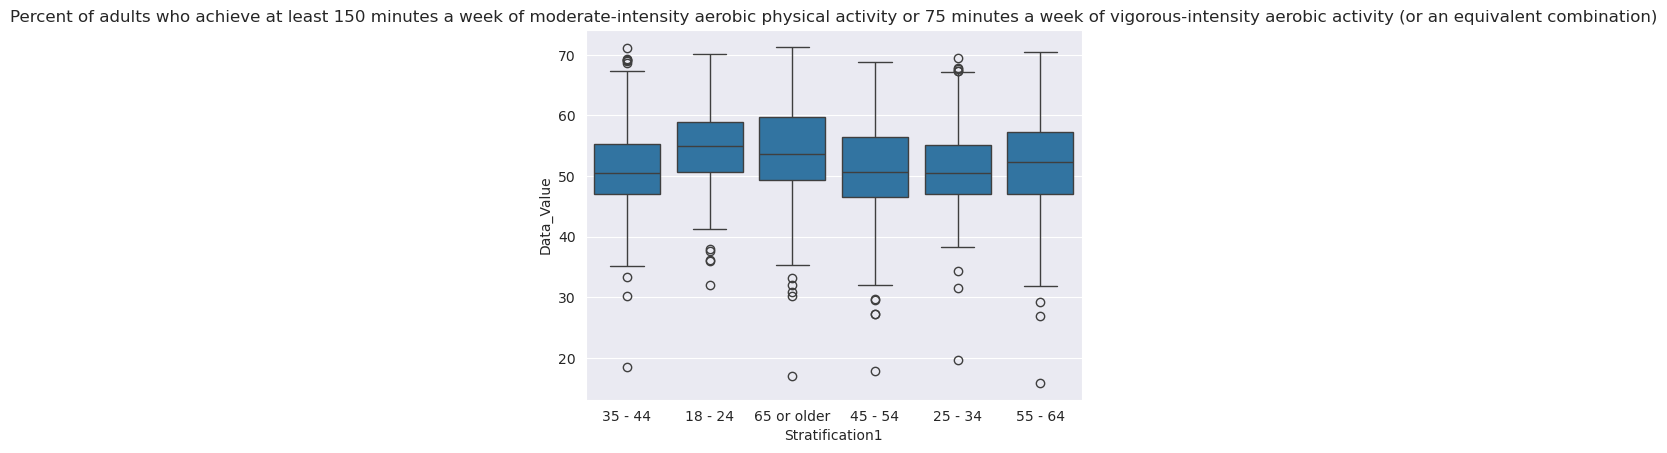

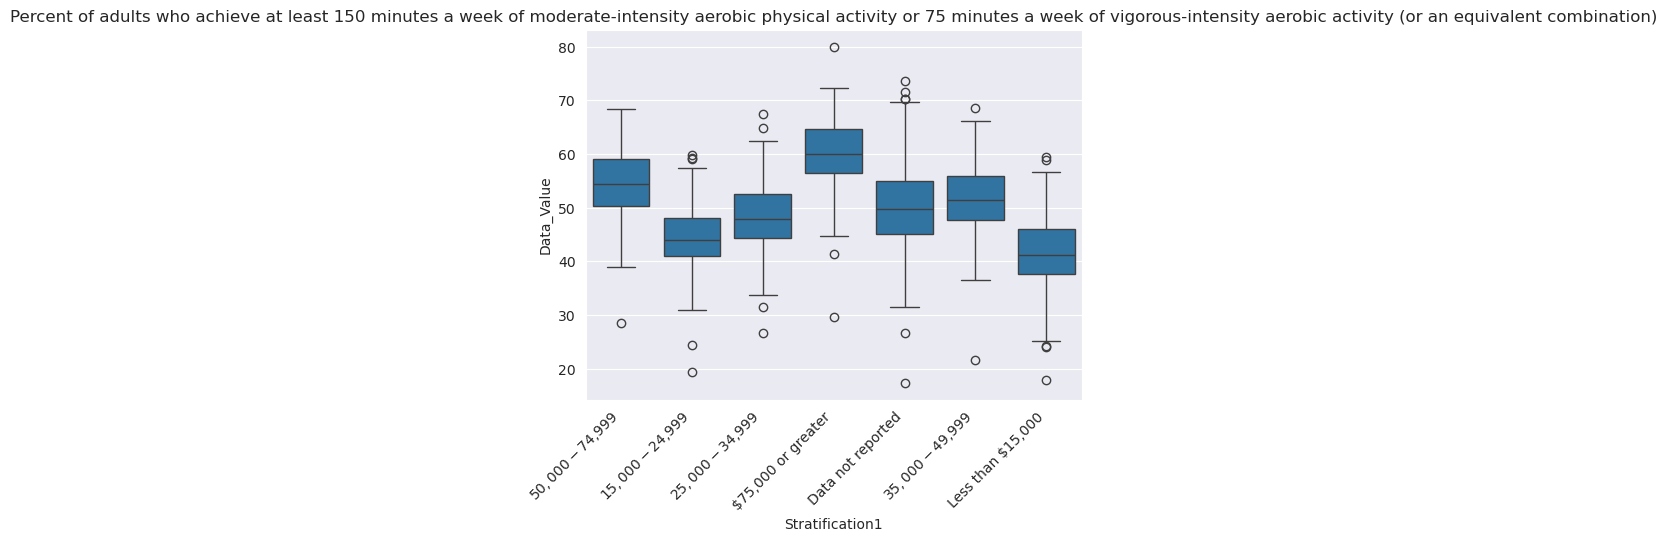

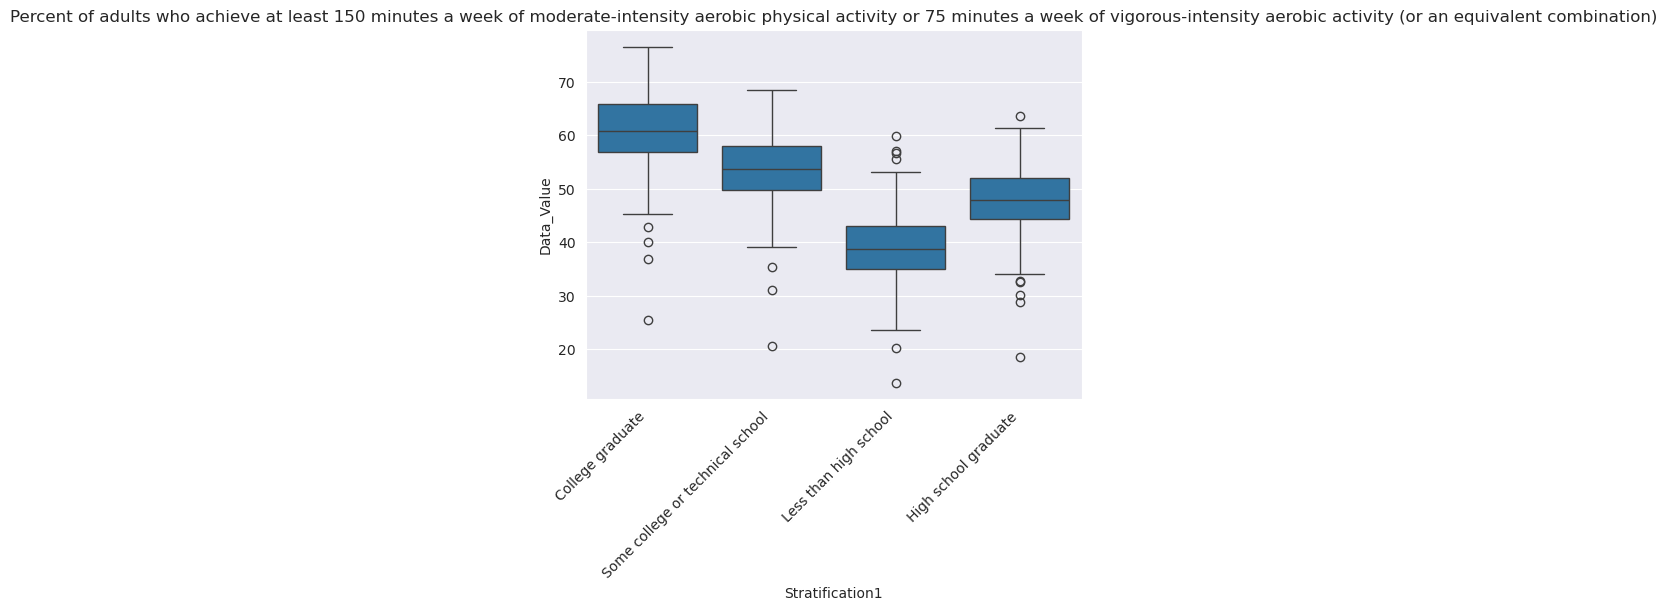

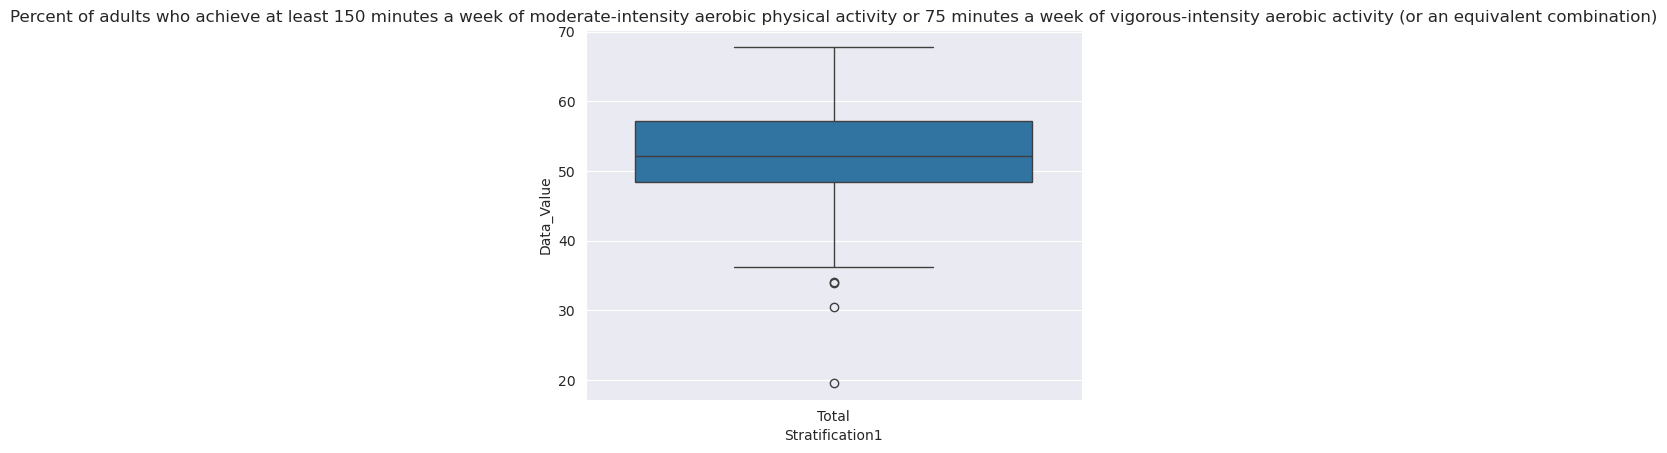

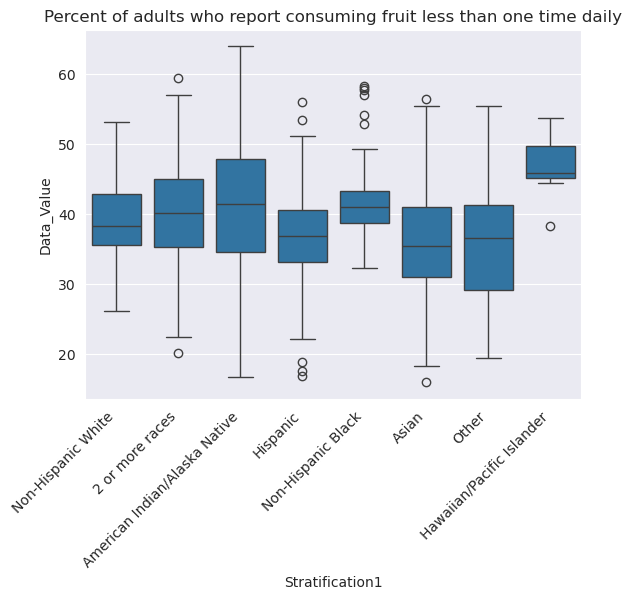

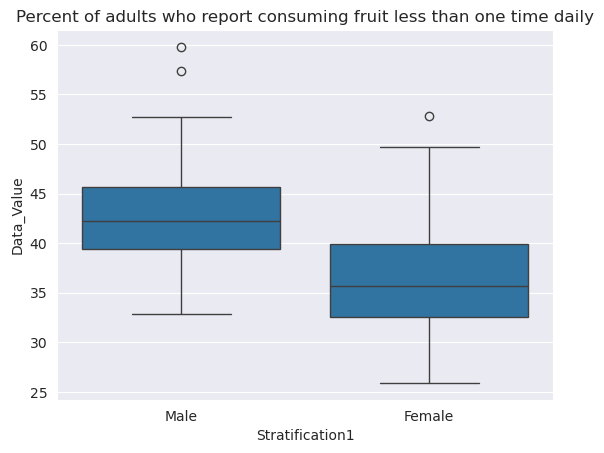

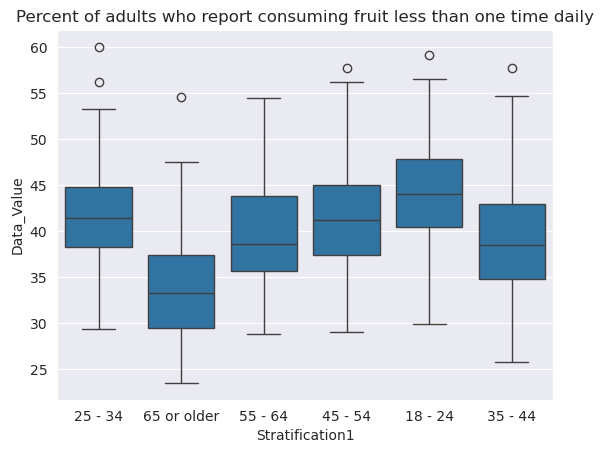

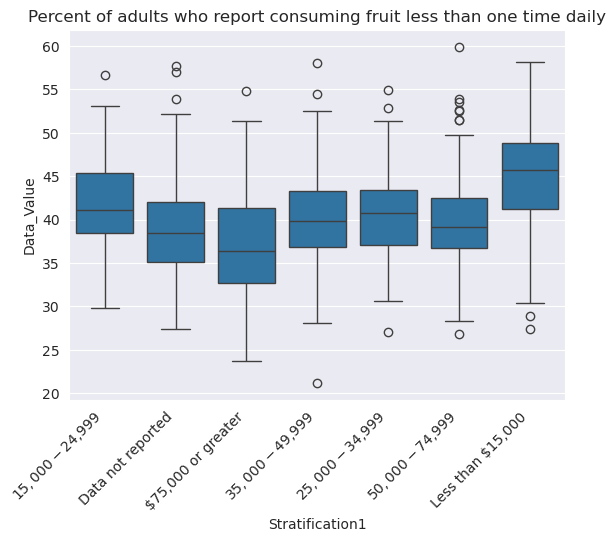

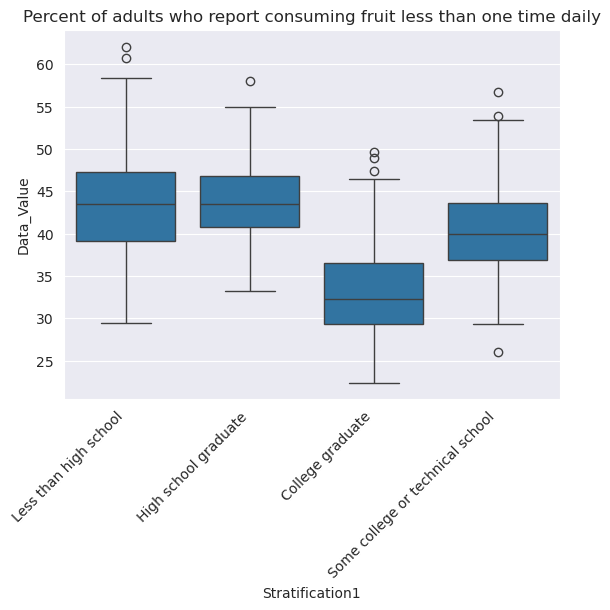

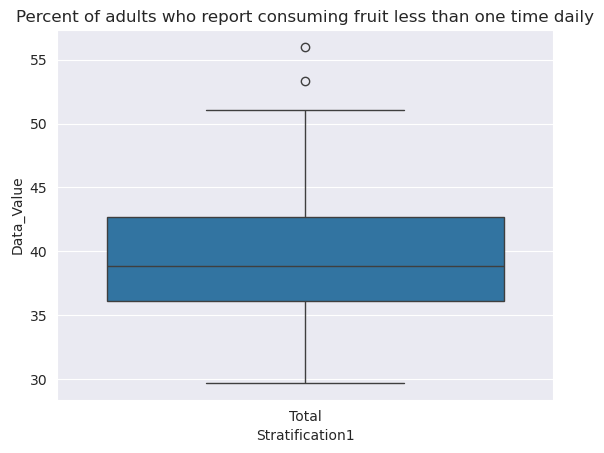

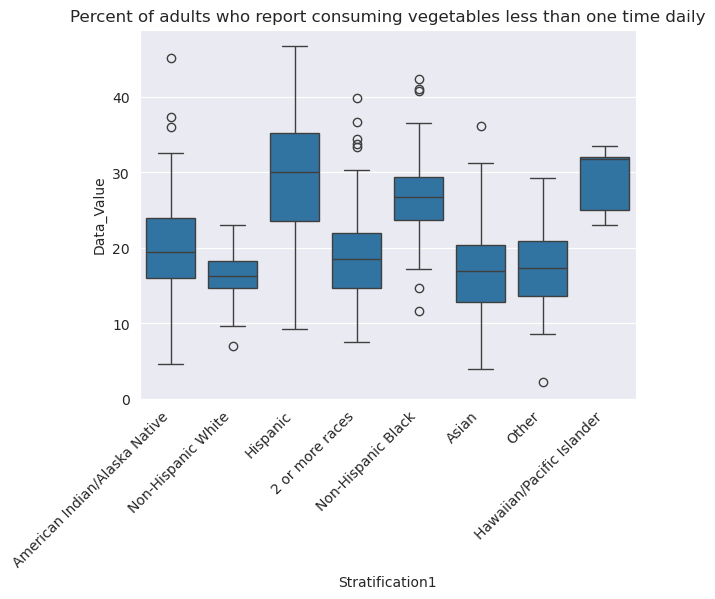

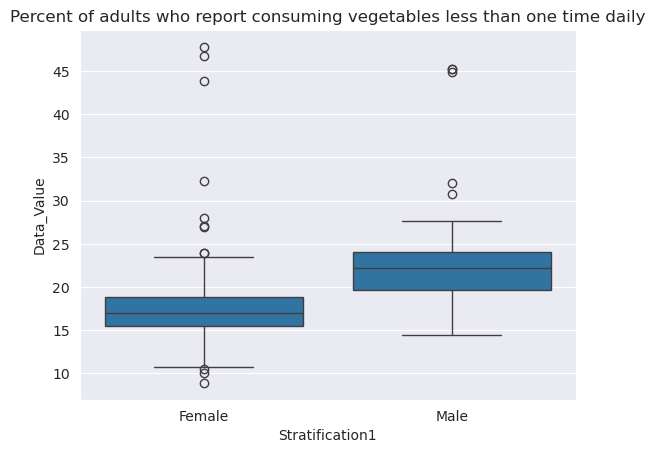

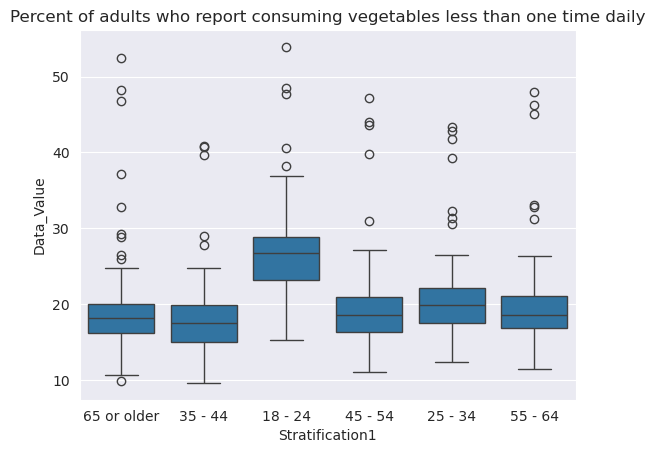

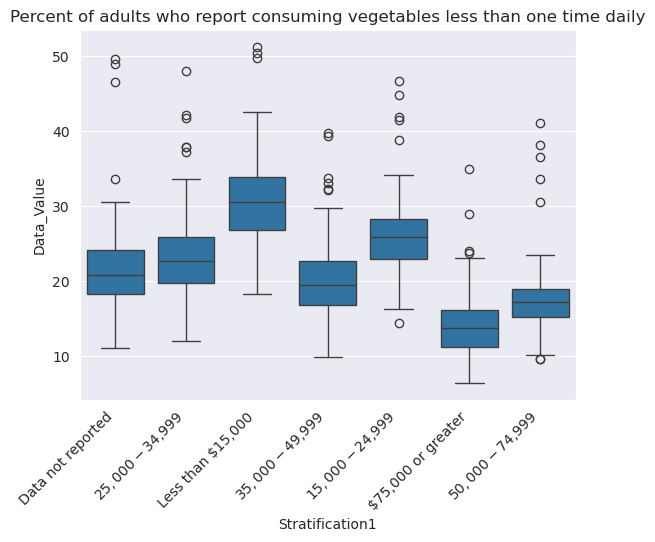

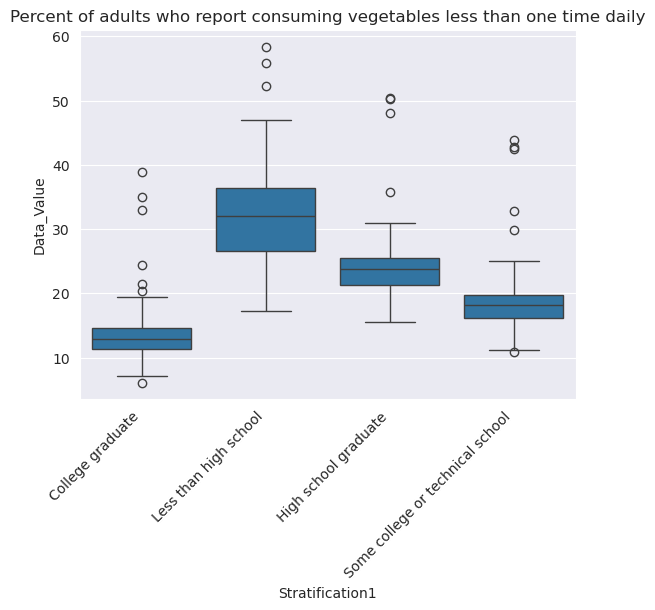

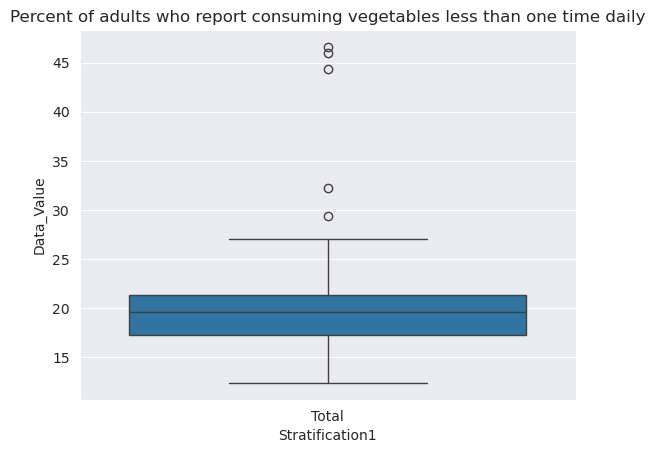

In [13]:
# Categorical plots
dataframes = [race_df, gender_df, age_df, income_df, education_df, total_df]

# I wanted to try and make subplots for each category but im eepy and its like 3am
for q_index in range(len(questionIDS)):
    for d in dataframes:
        strats_one = d['StratificationCategory1'].unique()
        temp_df = d[d['QuestionID'] == questionIDS[q_index]]
        ax = sns.boxplot(data=temp_df, x='Stratification1', y='Data_Value')
        ax.set_title(f"{questionUnique[q_index]}")
        max_label_len = max(len(label) for label in [temp.get_text() for temp in ax.get_xticklabels()])
        if max_label_len > 17:
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
        else:
            plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
        plt.show()


In [ ]:
# Numerical Data

#Didn't wanna scroll up lol
#race_df = df[df['StratificationCategory1'] == 'Race/Ethnicity'].copy(deep=True)
#gender_df = df[df['StratificationCategory1'] == 'Gender'].copy(deep=True)
#age_df = df[df['StratificationCategory1'] == 'Age (years)'].copy(deep=True)
#income_df = df[df['StratificationCategory1'] == 'Income'].copy(deep=True)
#education_df = df[df['StratificationCategory1'] == 'Education'].copy(deep=True)
#total_df = df[df['StratificationCategory1'] == 'Total'].copy(deep=True)
#Features:  Index(['YearStart', 'LocationDesc', 'Question', 'Data_Value',
#       'Low_Confidence_Limit', 'High_Confidence_Limit ', 'Sample_Size',
#       'Total', 'Age(years)', 'Education', 'Gender', 'Income',
#       'Race/Ethnicity', 'GeoLocation', 'ClassID', 'TopicID', 'QuestionID',
#       'StratificationCategory1', 'Stratification1'],
#      dtype='object')
#Strat IDS:  ['Race/Ethnicity' 'Gender' 'Age (years)' 'Income' 'Education' 'Total']

# Age

# I wish we had age and income kinstead we have income and percent of how healthy someone is

# Split upt graphs based on location and then an overall one

#Just copied this over from the other notebook
# percent of question vs income
#columns_for_clustering = [
#    "Model-Based Percent-colonoscopy",
#    "Model-Based Percent-pap_smear",
#    "Value (Dollars)",
#    "Value (Index)",
#    "Value (Percent)"
#]
#race_cluster_df = race_df[columns_for_clustering]
#gender_cluster_df = gender_df[columns_for_clustering]
#age_cluster_df = age_df[columns_for_clustering]
#income_cluster_df = income_df[columns_for_clustering]
#education_cluster_df = education_df[columns_for_clustering]
#total_cluster_df = total_df[columns_for_clustering]
#
#nan_count = df.isna().sum()
#print("Missing data")
#print(nan_count)
#print(df_cluster.dtypes)
## Handle missing values by filling them with the mean (you can choose a different method)
#df_cluster = df_cluster.fillna(df_cluster.mean())
#
## Standardize the data (important for K-Means clustering)
#scaler = StandardScaler()
#df_scaled = scaler.fit_transform(df_cluster)

# i guess for numerical data we can take at the distribution of the different classes.
# Can also do something with the state (obviously the question that was asked too)
# but that's something for not 5am brain.



In [14]:
# Geolocation Analysis
#  GeoLocation

# Makes things easier adds about 5 seconds sadly.
for d in dataframes:
    d[['latitude', 'longitude']] = d['GeoLocation'].apply(lambda x: pd.Series(x[1:-1].split(',')))
    d['latitude'] = pd.to_numeric(d['latitude'], errors='coerce')
    d['longitude'] = pd.to_numeric(d['longitude'], errors='coerce')


    YearStart LocationDesc                                           Question  \
0        2011       Alaska  Percent of adults aged 18 years and older who ...   
7        2011       Alaska  Percent of adults who engage in muscle-strengt...   
16       2011       Alaska  Percent of adults who achieve at least 150 min...   
23       2011       Alaska  Percent of adults who achieve at least 300 min...   
24       2011       Alaska  Percent of adults who engage in muscle-strengt...   

    Data_Value  Low_Confidence_Limit  High_Confidence_Limit   Sample_Size  \
0         35.5                  22.7                    50.9         63.0   
7         35.9                  33.2                    38.6       2417.0   
16        56.2                  44.9                    66.9        130.0   
23        33.8                  27.8                    40.4        428.0   
24        26.9                  18.2                    37.9        132.0   

                   Race/Ethnicity                 

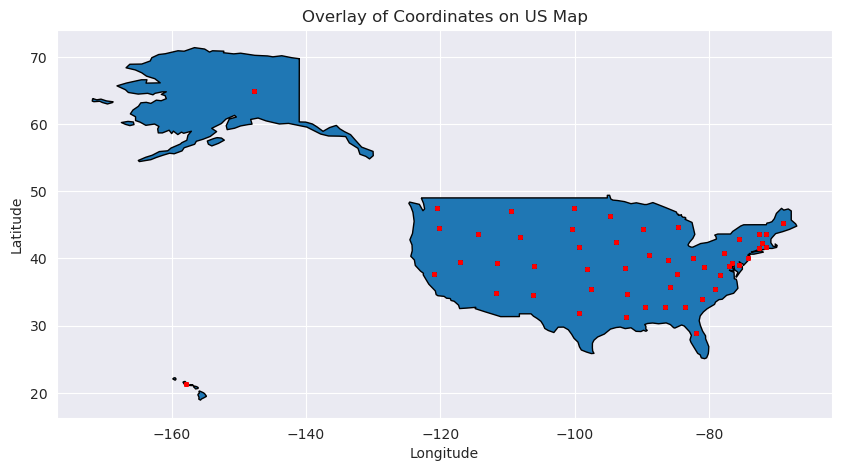

In [15]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
us = world[world.name == 'United States of America']
geometry = [Point(xy) for xy in zip(total_df['longitude'], total_df['latitude'])]

# Create a GeoDataFrame for points
gdf = gpd.GeoDataFrame(total_df, geometry=geometry)

# Filter points to only include those within the US
gdf = gdf[gdf.geometry.within(us.unary_union)]

# Plot map and overlay points
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
us.plot(ax=ax, edgecolor='black')
gdf.plot(ax=ax, marker='o', color='red', markersize=5)
plt.title("Overlay of Coordinates on US Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# All the Graphs ended up looking the same which makes sense
# since its just coordinates

# Maybe we can do something with the sample sizes at those states.
# Like making it a heat map of some sort where its like given a state
# adjust the color of the point based on how 'Healthy an individual is'.
# Since there a bunch of questions in the dataset like percent that are
# obese, overweight, workout etcetc we can make a score of some kinda that
# applies all these questions together to give an 'Overall health score'
# and then Color and do analysis based on that.

In [16]:
# Tokenize/Encode data

In [ ]:
# Other things to do When its not 5 am